# Projet 7 : Réalisez une analyse de sentiment grâce au Deep Learning

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Importation des librairies](#partie2.1)
    * [2.2 Répertoire des fonctions](#partie2.2)
    * [2.3 Chargement du jeu de données](#partie2.3)
* [3. EDA](#partie3)
    * [3.1 Exploration Initiale](#partie3.1)
    * [3.2 Nettoyage du dataframe](#partie3.2)
* [4. Prétraitement des données](#partie4)
    * [4.1 Nettoyage des données](#partie4.1)
    * [4.2 BoW et TF-IDF](#partie4.2)
* [5. Métrique Comparative : Buzz Score](#partie5)
* [6. Modélisation Simple](#partie6)
* [7. Modélisation Avancée](#partie7)
    * [7.1 Word Embedding](#partie7.1)
    * [7.2 Modélisation](#partie7.2)
* [8. Modèle BERT](#partie8)
    * [8.1 Pipeline Hugging Face (RoBERTa)](#partie8.1)
    * [8.2 Embeddings BERT + LSTM Bidirectionnel](#partie8.2)
    * [8.3 BERT Fine-Tuning (PyTorch)](#partie8.3)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Dans le cadre de mes missions en tant qu’ingénieur IA chez Marketing Intelligence Consulting (MIC), je suis chargé de développer un prototype d’intelligence artificielle pour la compagnie aérienne Air Paradis. Cette compagnie, soucieuse de son image sur les réseaux sociaux, fait face à des risques récurrents de « bad buzz », pouvant nuire à sa réputation et à la satisfaction de ses clients.

L’objectif de ce projet est de créer un produit IA capable d’anticiper ces bad buzz en analysant les tweets des utilisateurs et en prédisant leur tonalité (négative ou non). Air Paradis souhaite obtenir un modèle fonctionnel capable de classifier en temps réel le sentiment des tweets, via une API déployée sur le Cloud. Ce produit doit ainsi permettre à la compagnie de réagir rapidement face à des publications négatives, limitant ainsi leur propagation.

De plus, ce projet s’inscrit dans une démarche plus large d’exploration de différentes approches de modélisation, notamment :

- Modèle sur mesure simple : un modèle classique pour prédire le sentiment.
- Modèle sur mesure avancé : un modèle de réseau de neurones avec l’utilisation de word embeddings.
- Modèle avancé BERT : une approche plus complexe utilisant un modèle BERT fine-tuné sur les tweets.

L’implémentation de ces modèles s’accompagne d’une démarche rigoureuse de MLOps afin d’assurer la gestion, le suivi et la mise en production du modèle dans les meilleures conditions. Le projet intègre notamment l’utilisation de MLFlow pour le tracking des expérimentations, ainsi que l’automatisation du déploiement via des pipelines CI/CD sur des plateformes Cloud gratuites comme Azure ou Heroku.

Ce projet, bien que centré sur Air Paradis, a également pour ambition d’être généralisé à d’autres secteurs ou entreprises souhaitant maîtriser leur image en ligne.

## <font color='red'>2. Préparation de l'environnement </font><a class="anchor" id="partie2"></a>

### <font color='blue'> Installion des modules</font>

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install gensim

In [ ]:
!pip install tensorflow tensorflow-hub

In [ ]:
!pip install pyngrok

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.7 MB/s eta 0:00:00


### <font color='blue'>2.1 Importation des librairies / Préparation MLFlow</font><a class="anchor" id="partie2.1">

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
import subprocess
from pyngrok import ngrok
import mlflow
import mlflow.pytorch
import nltk
import torch
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers.legacy import Adam
from collections import Counter
import transformers
from transformers import BertModel, TFBertModel, BertTokenizer, BertForSequenceClassification, pipeline
from torch.optim import AdamW
import tensorflow as tf
import tensorflow_hub as hub
from torch.utils.data import DataLoader, Dataset
import time
from gensim.models import Word2Vec, FastText

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Démarrer le serveur MLFlow en arrière-plan
mlflow_server = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

In [ ]:
!ngrok config add-authtoken 2o7fRSSTsKkRHY1jl4VoX9qS7AR_5TCYPvixQ8rv7g5PqJp8t

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Créer un tunnel pour le port 5000
public_url = ngrok.connect(5000)
print("MLFlow Tracking UI:", public_url)

MLFlow Tracking UI: NgrokTunnel: "https://b536-35-201-131-138.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# Définir le titre du projet dans MLFlow
mlflow.set_experiment("Analyse de Sentiment des Tweets - Projet 7")

2024/12/21 11:16:21 INFO mlflow.tracking.fluent: Experiment with name 'Analyse de Sentiment des Tweets - Projet 7' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/547988210521596058', creation_time=1734779781131, experiment_id='547988210521596058', last_update_time=1734779781131, lifecycle_stage='active', name='Analyse de Sentiment des Tweets - Projet 7', tags={}>

In [ ]:
# Télécharger les ressources nécessaires pour la lemmatisation
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Initialiser le stemmer et le lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
stop_words = set(stopwords.words('english'))

### <font color='blue'>2.2 Répertoire des fonctions</font><a class="anchor" id="partie2.2"></a>

##### <font color='purple'>Fonctions génériques</font>

In [ ]:
def nettoyer_texte(texte):
    """
    Nettoie le texte en supprimant les URL, les mentions, la ponctuation, les chiffres,
    les stop words et en développant les contractions. Ajoute les hashtags extraits
    à la fin du texte.

    Args:
        texte (str): Texte à nettoyer.

    Returns:
        str: Texte nettoyé.
    """
    # Convertir en minuscules
    texte = texte.lower()
    # Développer les contractions courantes
    texte = contractions.fix(texte)
    # Retirer les URL
    texte = re.sub(r"http\S+|www\S+|https\S+", '', texte, flags=re.MULTILINE)
    # Retirer les mentions d'utilisateurs
    texte = re.sub(r'@\w+', '', texte)
    # Extraire et conserver les hashtags
    hashtags = re.findall(r'#(\w+)', texte)
    texte = re.sub(r'#\w+', '', texte)
    # Retirer les caractères spéciaux et la ponctuation
    texte = re.sub(r'[^\w\s]', '', texte)
    # Retirer les chiffres
    texte = re.sub(r'\d+', '', texte)
    # Retirer les stop words
    texte = ' '.join([word for word in texte.split() if word not in stop_words])
    # Retirer les espaces multiples et superflus
    texte = re.sub(r'\s+', ' ', texte).strip()
    # Ajouter les hashtags extraits à la fin du texte
    if hashtags:
        texte = f"{texte} {' '.join(hashtags)}"

    return texte

In [ ]:
# Fonction de stemmatisation
def stemmer_texte(texte):
    tokens = nltk.word_tokenize(texte)
    return ' '.join([stemmer.stem(token) for token in tokens])

In [ ]:
# Fonction de lemmatisation
def lemmatizer_texte(texte):
    tokens = nltk.word_tokenize(texte)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
# Fonction pour appliquer BoW, TF-IDF classique ou TF-IDF avec N-grams avec MLFlow
def vectorize_and_log(df, column_name, vectorization_type="BoW", max_features=1000, ngram_range=(1, 1)):
    """
    Vectorise une colonne de texte et logue les paramètres et résultats dans MLFlow.

    Args:
        df (pd.DataFrame): DataFrame contenant les données.
        column_name (str): Nom de la colonne à vectoriser.
        vectorization_type (str): Type de vectorisation ("BoW", "TF-IDF", "TF-IDF N-grams").
        max_features (int): Nombre maximal de features à conserver.
        ngram_range (tuple): Plage de N-grams à inclure (par exemple, (1, 2) pour unigrams et bigrams).

    Returns:
        scipy.sparse.csr_matrix: Matrice vectorisée.
    """
    # Choix du vectorizer
    if vectorization_type == "BoW":
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    elif vectorization_type == "TF-IDF" or vectorization_type == "TF-IDF N-grams":
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    else:
        raise ValueError(f"Type de vectorisation non pris en charge : {vectorization_type}")

    # Créer la matrice
    matrix = vectorizer.fit_transform(df[column_name])

    # Logging dans MLFlow
    with mlflow.start_run(run_name=f"Vectorisation {vectorization_type} - {column_name}", nested=True):
        mlflow.log_param("vectorisation_type", vectorization_type)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("dimensionnalite", matrix.shape)

        # Enregistrer un échantillon du vocabulaire
        vocab_sample = list(vectorizer.vocabulary_.keys())[:10]
        mlflow.log_text(str(vocab_sample), f"vocabulaire_{vectorization_type}_{column_name}_sample.txt")

    return matrix

In [ ]:
# Fonction pour afficher les courbes d'apprentissage
def plot_learning_curves(all_history, model_name="", mean_scores=None):
    """
    Affiche et enregistre les courbes d'apprentissage dans MLFlow avec les scores moyens dans les légendes.

    Args:
        all_history (dict): Dictionnaire contenant les historiques de 'loss', 'val_loss', 'accuracy', et 'val_accuracy'.
        model_name (str): Nom du modèle à afficher sur les graphiques.
        mean_scores (dict): Dictionnaire contenant les scores moyens à afficher.
    """
    plt.figure(figsize=(12, 5))

    # Courbe de la loss
    plt.subplot(1, 2, 1)
    plt.plot(all_history['loss'], label=f'Train Loss (Mean AUC: {mean_scores["Mean_AUC"]:.2f})')
    plt.plot(all_history['val_loss'], label=f'Validation Loss (Mean F1: {mean_scores["Mean_F1_Score"]:.2f})')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Learning Curve (Loss)")
    plt.legend()

    # Courbe de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(all_history['accuracy'], label=f'Train Accuracy (Mean Precision: {mean_scores["Mean_Precision"]:.2f})')
    plt.plot(all_history['val_accuracy'], label=f'Validation Accuracy (Mean Recall: {mean_scores["Mean_Recall"]:.2f})')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Learning Curve (Accuracy)")
    plt.legend()

    plt.tight_layout()
    curve_path = f"{model_name}_learning_curves.png"
    plt.savefig(curve_path)
    mlflow.log_artifact(curve_path)
    plt.show()

In [ ]:
def build_dense_model(input_dim):
    """
    Construit et compile un modèle Dense pour la classification binaire.

    Args:
        input_dim (int): Dimension de l'entrée (nombre de features).

    Returns:
        Model: Modèle Dense compilé.
    """
    model = Sequential([
        Input(shape=(input_dim,)),  # Couche d'entrée spécifiée
        Dense(128, activation='relu'),
        Dropout(0.5),  # Regularisation pour éviter l'overfitting
        Dense(64, activation='relu'),
        Dropout(0.5),  # Deuxième couche Dropout
        Dense(1, activation='sigmoid')  # Couche de sortie pour classification binaire
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_lstm_model(input_shape, bidirectional=False):
    """
    Construit et compile un modèle LSTM avec une option bidirectionnelle.

    Args:
        input_shape (tuple): Shape des données d'entrée pour le modèle (timesteps, features).
        bidirectional (bool): Si True, utilise un LSTM bidirectionnel.

    Returns:
        Sequential: Modèle LSTM compilé.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))  # Utilisation de input_shape directement

    if bidirectional:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    else:
        model.add(LSTM(64, return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Fonction pour s'assurer que tous les runs actifs sont fermés avant d'en démarrer un nouveau
def ensure_no_active_run():
    while mlflow.active_run() is not None:
        mlflow.end_run()

##### <font color='purple'>Fonctions pour les modeles ML</font>

In [ ]:
def train_and_evaluate_ml_model(
    model, model_name, embedding_data, labels, embedding_type="Word2Vec", text_version="Cleaned"
):
    """
    Entraîne et évalue un modèle de ML avec validation croisée stratifiée sur le train,
    et effectue une évaluation finale sur un jeu de test séparé.

    Args:
        model (sklearn model): Modèle à entraîner et évaluer.
        model_name (str): Nom du modèle (par exemple, "Logistic Regression", "SVM").
        embedding_data (np.array): Données d'entrée vectorisées par l'embedding choisi.
        labels (np.array): Labels pour la classification (0 pour négatif, 1 pour positif).
        embedding_type (str): Nom de l'embedding utilisé (par exemple, "Word2Vec", "TF-IDF").
        text_version (str): Version du texte utilisée (Cleaned, Stemmed, Lemmatized).

    Returns:
        metrics (dict): Dictionnaire contenant les métriques moyennes calculées (AUC, Precision, Recall, F1).
        execution_time (float): Temps d'exécution en secondes pour le modèle.
    """
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

    # Assurer la compatibilité des données avec certains modèles comme LightGBM
    embedding_data = embedding_data.astype('float32')
    labels = labels.astype('float32')

    # Séparer en train/validation et test
    X_train, X_test, y_train, y_test = train_test_split(
        embedding_data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialiser les listes pour les scores et la matrice de confusion cumulative
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])

    # Initialiser les courbes ROC globales
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    # Accumulateur pour les courbes d'apprentissage
    all_train_accuracies, all_val_accuracies = [], []

    # Démarrer le chronomètre pour le temps d'exécution
    start_time = time.time()

    # Démarrer le run principal MLflow
    with mlflow.start_run(run_name=f"{model_name} - {embedding_type}", nested=True):
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"\n--- Pli {fold + 1} ---")
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Entraîner le modèle
            model.fit(X_fold_train, y_fold_train)
            train_accuracy = model.score(X_fold_train, y_fold_train)
            val_accuracy = model.score(X_fold_val, y_fold_val)
            all_train_accuracies.append(train_accuracy)
            all_val_accuracies.append(val_accuracy)

            # Prédictions et métriques
            y_pred_proba = (
                model.predict_proba(X_fold_val)[:, 1]
                if hasattr(model, 'predict_proba')
                else model.decision_function(X_fold_val)
            )
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc = roc_auc_score(y_fold_val, y_pred_proba)
            precision = precision_score(y_fold_val, y_pred_binary)
            recall = recall_score(y_fold_val, y_pred_binary)
            f1_metric = f1_score(y_fold_val, y_pred_binary)
            cm = confusion_matrix(y_fold_val, y_pred_binary)

            # Calcul des courbes ROC pour chaque pli
            fpr, tpr, _ = roc_curve(y_fold_val, y_pred_proba)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))
            tpr_list[-1][0] = 0.0

            # Enregistrement des scores
            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1_metric)
            cumulative_cm += cm

        # Scores moyens
        mean_auc = np.mean(auc_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)

        # Calcul du Buzz Score
        buzz_score = (0.4 * mean_recall) + (0.3 * mean_f1) + (0.2 * mean_auc) + (0.1 * mean_precision)

        # Loguer toutes les métriques moyennes dans MLflow
        mlflow.log_metric("Buzz_Score", buzz_score)
        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)

        # Évaluation finale sur le test set
        model.fit(X_train, y_train)
        y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        y_test_binary = (y_test_proba > 0.5).astype(int)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_binary)
        test_recall = recall_score(y_test, y_test_binary)
        test_f1 = f1_score(y_test, y_test_binary)

        # Calcul du Buzz Score pour le test
        test_buzz_score = (0.4 * test_recall) + (0.3 * test_f1) + (0.2 * test_auc) + (0.1 * test_precision)

        # Loguer toutes les métriques du jeu de test dans MLflow
        mlflow.log_metric("Test_Buzz_Score", test_buzz_score)
        mlflow.log_metric("Test_AUC", test_auc)
        mlflow.log_metric("Test_Precision", test_precision)
        mlflow.log_metric("Test_Recall", test_recall)
        mlflow.log_metric("Test_F1_Score", test_f1)

        print(f"\n--- Résultats sur le jeu de test ---")
        print(f"AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

    execution_time = time.time() - start_time

    return {
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1,
        "Buzz Score": buzz_score,
        "Test AUC": test_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Buzz Score": test_buzz_score
    }, execution_time

In [ ]:
def test_text_versions(df_sample, final_models):
    results = []
    for text_version in ["text_cleaned", "text_stemmed", "text_lemmatized"]:
        if mlflow.active_run():
            print(f"Fermeture d'un run actif avant d'en démarrer un nouveau : {mlflow.active_run().info.run_id}")
            mlflow.end_run()
        run_name = f"Prétraitement - {text_version}"
        with mlflow.start_run(run_name=run_name, nested=False):
            mlflow.set_tag("Phase", "Prétraitement")
            mlflow.set_tag("Version Texte", text_version)

            # Obtenir la matrice de features (BoW)
            X = vectorize_and_log(df_sample, text_version, vectorization_type="BoW")
            y = df_sample['sentiment'].values

            # Entraîner et évaluer la régression logistique
            print(f"\nEntraînement de la Régression Logistique avec {text_version}")
            metrics, execution_time = train_and_evaluate_ml_model(
                model=final_models["Logistic Regression"],
                model_name="Logistic Regression",
                embedding_data=X,
                labels=y,
                embedding_type="BoW",
                text_version=text_version
            )
            results.append({
                "Text Version": text_version,
                "Mean AUC": metrics["Mean AUC"],
                "Mean Precision": metrics["Mean Precision"],
                "Mean Recall": metrics["Mean Recall"],
                "Mean F1 Score": metrics["Mean F1 Score"],
                "Execution Time (s)": execution_time
            })

    # Affichage des résultats
    results_df = pd.DataFrame(results)
    print("=== Résultats de l'Étape 1 : Versions de Texte ===")
    print(results_df)
    return results_df

In [ ]:
def test_vectorizations(df_sample, final_models, best_preprocessing):
    results = []
    vectorization_methods = ["BoW", "TF-IDF", "TF-IDF N-grams"]  # Ajout de TF-IDF N-grams

    for vectorization_type in vectorization_methods:
        if mlflow.active_run():
            print(f"Fermeture d'un run actif avant d'en démarrer un nouveau : {mlflow.active_run().info.run_id}")
            mlflow.end_run()

        run_name = f"Vectorisation - {best_preprocessing} - {vectorization_type}"
        with mlflow.start_run(run_name=run_name, nested=False):
            mlflow.set_tag("Phase", "Vectorisation")
            mlflow.set_tag("Version Texte", best_preprocessing)
            mlflow.set_tag("Type de Vectorisation", vectorization_type)

            # Obtenir la matrice de features avec vectorisation et logs
            if vectorization_type == "TF-IDF N-grams":
                # Spécifier les paramètres des N-grams
                X = vectorize_and_log(
                    df_sample,
                    column_name=best_preprocessing,
                    vectorization_type="TF-IDF",
                    ngram_range=(1, 2)
                )
            else:
                # BoW ou TF-IDF classique
                X = vectorize_and_log(
                    df_sample,
                    column_name=best_preprocessing,
                    vectorization_type=vectorization_type
                )

            y = df_sample['sentiment'].values

            # Entraîner et évaluer la Régression Logistique
            print(f"\nEntraînement de la Régression Logistique avec {vectorization_type}")
            metrics, execution_time = train_and_evaluate_ml_model(
                model=final_models["Logistic Regression"],
                model_name="Logistic Regression",
                embedding_data=X,
                labels=y,
                embedding_type=vectorization_type,
                text_version=best_preprocessing
            )

            # Ajouter les résultats pour cette vectorisation
            results.append({
                "Vectorization": vectorization_type,
                "Mean AUC": metrics["Mean AUC"],
                "Mean Precision": metrics["Mean Precision"],
                "Mean Recall": metrics["Mean Recall"],
                "Mean F1 Score": metrics["Mean F1 Score"],
                "Execution Time (s)": execution_time
            })

    # Affichage des résultats
    results_df = pd.DataFrame(results)
    print("=== Résultats de l'Étape 2 : Vectorisations ===")
    print(results_df)
    return results_df

In [ ]:
def test_models(df_sample, final_models, best_preprocessing, best_vectorization):
    results = []
    for model_name, model in final_models.items():
        if mlflow.active_run():
            print(f"Fermeture d'un run actif avant d'en démarrer un nouveau : {mlflow.active_run().info.run_id}")
            mlflow.end_run()
        run_name = f"Modèle Final - {model_name}"
        with mlflow.start_run(run_name=run_name, nested=False):
            mlflow.set_tag("Phase", "Modèles Finaux")
            mlflow.set_tag("Version Texte", best_preprocessing)
            mlflow.set_tag("Type de Vectorisation", best_vectorization)

            # Obtenir la matrice de features
            X = vectorize_and_log(df_sample, best_preprocessing, vectorization_type=best_vectorization)
            y = df_sample['sentiment'].values

            try:
                # Entraîner et évaluer le modèle
                print(f"\nEntraînement de {model_name}")
                metrics, execution_time = train_and_evaluate_ml_model(
                    model=model,
                    model_name=model_name,
                    embedding_data=X,
                    labels=y,
                    embedding_type=best_vectorization,
                    text_version=best_preprocessing
                )
                results.append({
                    "Model": model_name,
                    "Mean AUC": metrics["Mean AUC"],
                    "Mean Precision": metrics["Mean Precision"],
                    "Mean Recall": metrics["Mean Recall"],
                    "Mean F1 Score": metrics["Mean F1 Score"],
                    "Execution Time (s)": execution_time
                })
            except Exception as e:
                # Capturer et afficher les erreurs pour ce modèle
                print(f"Erreur lors de l'entraînement de {model_name}: {str(e)}")
                mlflow.log_param("Erreur", f"{model_name}: {str(e)}")

    # Affichage des résultats
    results_df = pd.DataFrame(results)
    print("=== Résultats de l'Étape 3 : Modèles ML ===")
    print(results_df)
    return results_df

##### <font color='purple'>Fonctions pour les embeddings</font>

###### Word2Vec & FastText

In [ ]:
# Calculer la moyenne des embeddings Word2Vec pour chaque tweet
def get_avg_word2vec_embeddings(text_data, model, vector_size):
    """
    Calcule la moyenne des embeddings Word2Vec pour chaque tweet.

    Args:
        text_data (iterable): Liste de tweets sous forme de listes de mots.
        model (Word2Vec): Modèle Word2Vec entraîné.
        vector_size (int): Taille des vecteurs Word2Vec.

    Returns:
        np.array: Tableau contenant les embeddings moyens pour chaque tweet.
    """
    embeddings = []
    for tweet in text_data:
        # Extraire les vecteurs de mots et calculer la moyenne
        word_vectors = [model.wv[word] for word in tweet if word in model.wv]
        if word_vectors:
            avg_vector = np.mean(word_vectors, axis=0)
        else:
            avg_vector = np.zeros(vector_size)  # Vecteur nul si aucun mot n'est présent dans Word2Vec
        embeddings.append(avg_vector)
    return np.array(embeddings)

###### Glove

In [ ]:
# Charger les vecteurs GloVe à partir d'un fichier préentraîné
def load_glove_vectors(file_path):
    """
    Charge les vecteurs GloVe à partir d'un fichier texte.

    Args:
        file_path (str): Chemin vers le fichier GloVe (e.g., 'glove.6B.100d.txt').

    Returns:
        dict: Un dictionnaire où les clés sont les mots et les valeurs sont les vecteurs.
    """
    embeddings_index = {}
    with open(file_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [ ]:
# Calculer les embeddings moyens pour chaque phrase en utilisant GloVe
def get_avg_glove_embeddings(text_data, embeddings_index, vector_size):
    """
    Calcule la moyenne des embeddings GloVe pour chaque phrase.

    Args:
        text_data (iterable): Liste de phrases sous forme de listes de mots.
        embeddings_index (dict): Dictionnaire contenant les vecteurs GloVe.
        vector_size (int): Taille des vecteurs GloVe.

    Returns:
        np.array: Tableau contenant les embeddings moyens pour chaque phrase.
    """
    embeddings = []
    for tweet in text_data:
        word_vectors = [embeddings_index[word] for word in tweet if word in embeddings_index]

        if word_vectors:
            # Calculer la moyenne seulement si des vecteurs existent
            avg_vector = np.mean(word_vectors, axis=0)
        else:
            # Vecteur nul si aucun mot n'est présent
            avg_vector = np.zeros(vector_size, dtype=np.float32)

        # S'assurer que avg_vector a la bonne dimension
        if avg_vector.shape != (vector_size,):
            avg_vector = np.zeros(vector_size, dtype=np.float32)

        embeddings.append(avg_vector)

    # Convertir en tableau numpy proprement
    return np.array(embeddings, dtype=np.float32)

###### ELMo

In [ ]:
# Fonction pour transformer les tweets en embeddings par lots
def batch_embeddings_elmo(sentences, batch_size=128):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_emb = elmo_model.signatures['default'](tf.constant(batch))['elmo']
        embeddings.append(tf.reduce_mean(batch_emb, axis=1).numpy())
    return np.vstack(embeddings)

###### USE

In [ ]:
# Fonction pour transformer les tweets en embeddings par lots
def batch_embeddings(sentences, batch_size=128):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_emb = use_model(batch)
        embeddings.append(batch_emb.numpy())
    return np.vstack(embeddings)

###### BERT

In [ ]:
# Fonction pour obtenir les embeddings de phrase avec BERT par lots
def get_bert_embeddings_batch(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)
        outputs = bert_model(inputs)
        sentence_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)  # Moyenne sur la séquence
        all_embeddings.append(sentence_embeddings.numpy())
    return np.vstack(all_embeddings)

##### <font color='purple'>Fonctions pour les modeles KERAS</font>

In [ ]:
def train_and_evaluate_keras_model_dense(model_name, embedding_data, labels, embedding_type):
    """
    Entraîne et évalue un modèle Keras Dense avec validation croisée stratifiée sur le train
    et effectue une évaluation finale sur un jeu de test séparé.
    Enregistre les métriques, le Buzz Score, et les artefacts (courbes et matrice de confusion).

    Args:
        model_name (str): Nom du modèle.
        embedding_data (np.array): Données d'entrée vectorisées.
        labels (np.array): Labels pour la classification.
        embedding_type (str): Type d'embedding utilisé.

    Returns:
        dict: Contenant les métriques moyennes et de test.
        float: Temps d'exécution total.
    """
    global model_scores_keras

    if mlflow.active_run():
        mlflow.end_run()

    # Séparation train/test
    X_train, X_test, y_train, y_test = train_test_split(
        embedding_data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])
    all_train_loss, all_val_loss = [], []
    all_train_acc, all_val_acc = [], []

    # Initialiser la courbe ROC
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    start_time = time.time()

    with mlflow.start_run(run_name=f"{model_name} - {embedding_type}"):
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"\n--- Pli {fold + 1} ---")
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Construire et entraîner le modèle Dense
            model = build_dense_model(input_dim=X_fold_train.shape[1])
            history = model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_val, y_fold_val),
                                epochs=20, batch_size=64, verbose=0)

            # Historique pour les courbes d'apprentissage
            all_train_loss.append(history.history['loss'])
            all_val_loss.append(history.history['val_loss'])
            all_train_acc.append(history.history['accuracy'])
            all_val_acc.append(history.history['val_accuracy'])

            # Prédictions
            y_pred_proba = model.predict(X_fold_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc = roc_auc_score(y_fold_val, y_pred_proba)
            precision = precision_score(y_fold_val, y_pred_binary)
            recall = recall_score(y_fold_val, y_pred_binary)
            f1 = f1_score(y_fold_val, y_pred_binary)
            cm = confusion_matrix(y_fold_val, y_pred_binary)

            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            cumulative_cm += cm

            # Courbe ROC
            fpr, tpr, _ = roc_curve(y_fold_val, y_pred_proba)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))

        # Moyennes des métriques
        mean_auc, mean_precision, mean_recall, mean_f1 = map(np.mean, [auc_scores, precision_scores, recall_scores, f1_scores])
        buzz_score = (0.4 * mean_recall) + (0.3 * mean_f1) + (0.2 * mean_auc) + (0.1 * mean_precision)

        # Loguer chaque métrique moyenne dans MLflow
        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)
        mlflow.log_metric("Buzz_Score", buzz_score)

        # Sauvegarder la matrice de confusion cumulative
        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.title(f"Matrice de confusion - {model_name} ({embedding_type})")
        confusion_path = f"confusion_matrix_{model_name}_{embedding_type}.png"
        plt.savefig(confusion_path)
        mlflow.log_artifact(confusion_path)
        plt.show()

        # Courbes d'apprentissage
        plt.figure(figsize=(12, 5))
        plt.plot(np.mean(all_train_acc, axis=0), label='Train Accuracy')
        plt.plot(np.mean(all_val_acc, axis=0), label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Learning Curve - {model_name} ({embedding_type})")
        learning_curve_path = f"learning_curve_{model_name}_{embedding_type}.png"
        plt.savefig(learning_curve_path)
        mlflow.log_artifact(learning_curve_path)
        plt.show()

        # Évaluation sur le jeu de test
        model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
        y_test_proba = model.predict(X_test)
        y_test_binary = (y_test_proba > 0.5).astype(int)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_binary)
        test_recall = recall_score(y_test, y_test_binary)
        test_f1 = f1_score(y_test, y_test_binary)
        test_buzz_score = (0.4 * test_recall) + (0.3 * test_f1) + (0.2 * test_auc) + (0.1 * test_precision)

        mlflow.log_metric("Test_AUC", test_auc)
        mlflow.log_metric("Test_Precision", test_precision)
        mlflow.log_metric("Test_Recall", test_recall)
        mlflow.log_metric("Test_F1_Score", test_f1)
        mlflow.log_metric("Test_Buzz_Score", test_buzz_score)

    execution_time = time.time() - start_time
    return {
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1,
        "Buzz Score": buzz_score,
        "Test AUC": test_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Buzz Score": test_buzz_score
    }, execution_time

In [ ]:
def train_and_evaluate_keras_model_lstm(model_name, embedding_data, labels, embedding_type, bidirectional=False):
    """
    Entraîne et évalue un modèle Keras LSTM avec validation croisée stratifiée sur le train,
    et effectue une évaluation finale sur un jeu de test séparé.

    Args:
        model_name (str): Nom du modèle.
        embedding_data (np.array): Données d'entrée vectorisées.
        labels (np.array): Labels pour la classification.
        embedding_type (str): Type d'embedding utilisé.
        bidirectional (bool): Si True, utilise un LSTM bidirectionnel.

    Returns:
        dict: Métriques moyennes calculées sur le train/val et sur le jeu de test.
        float: Temps d'exécution en secondes pour le modèle.
    """
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
    from sklearn.model_selection import train_test_split, StratifiedKFold

    global model_scores_keras

    # Vérifier et redimensionner les données en 3D si nécessaire
    if len(embedding_data.shape) == 2:
        embedding_data = embedding_data[:, np.newaxis, :]

    # Séparation en Train/Validation et Test
    X_train, X_test, y_train, y_test = train_test_split(
        embedding_data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialiser les listes pour stocker les métriques
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])
    all_train_loss, all_val_loss, all_train_acc, all_val_acc = [], [], [], []

    # Initialiser les courbes ROC
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    start_time = time.time()

    # Entraînement avec validation croisée
    with mlflow.start_run(run_name=f"{model_name} - {embedding_type}", nested=True):
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"\n--- Pli {fold + 1} ---")
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Construire et entraîner le modèle LSTM
            model = build_lstm_model(input_shape=(X_fold_train.shape[1], X_fold_train.shape[2]), bidirectional=bidirectional)
            history = model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_val, y_fold_val),
                                epochs=20, batch_size=64, verbose=0)

            # Stocker les courbes d'apprentissage
            all_train_loss.append(history.history['loss'])
            all_val_loss.append(history.history['val_loss'])
            all_train_acc.append(history.history['accuracy'])
            all_val_acc.append(history.history['val_accuracy'])

            # Prédictions et métriques
            y_pred_proba = model.predict(X_fold_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            auc_scores.append(roc_auc_score(y_fold_val, y_pred_proba))
            precision_scores.append(precision_score(y_fold_val, y_pred_binary))
            recall_scores.append(recall_score(y_fold_val, y_pred_binary))
            f1_scores.append(f1_score(y_fold_val, y_pred_binary))

            cm = confusion_matrix(y_fold_val, y_pred_binary)
            cumulative_cm += cm

            # Courbe ROC
            fpr, tpr, _ = roc_curve(y_fold_val, y_pred_proba)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))

        # Moyennes des métriques
        mean_auc, mean_precision, mean_recall, mean_f1 = map(np.mean, [auc_scores, precision_scores, recall_scores, f1_scores])
        buzz_score = (0.4 * mean_recall) + (0.3 * mean_f1) + (0.2 * mean_auc) + (0.1 * mean_precision)

        # Loguer chaque métrique moyenne dans MLflow
        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)
        mlflow.log_metric("Buzz_Score", buzz_score)

        # Matrice de confusion cumulative
        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.title(f"Matrice de confusion - {model_name} ({embedding_type})")
        confusion_path = f"confusion_matrix_{model_name}_{embedding_type}.png"
        plt.savefig(confusion_path)
        mlflow.log_artifact(confusion_path)
        plt.show()

        # Courbes d'apprentissage
        plt.figure(figsize=(12, 5))
        plt.plot(np.mean(all_train_acc, axis=0), label='Train Accuracy')
        plt.plot(np.mean(all_val_acc, axis=0), label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Learning Curve - {model_name} ({embedding_type})")
        learning_curve_path = f"learning_curve_{model_name}_{embedding_type}.png"
        plt.savefig(learning_curve_path)
        mlflow.log_artifact(learning_curve_path)
        plt.show()

        # Évaluation finale sur le jeu de test
        model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
        y_test_proba = model.predict(X_test)
        y_test_binary = (y_test_proba > 0.5).astype(int)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_binary)
        test_recall = recall_score(y_test, y_test_binary)
        test_f1 = f1_score(y_test, y_test_binary)
        test_buzz_score = (0.4 * test_recall) + (0.3 * test_f1) + (0.2 * test_auc) + (0.1 * test_precision)

        mlflow.log_metric("Test_AUC", test_auc)
        mlflow.log_metric("Test_Precision", test_precision)
        mlflow.log_metric("Test_Recall", test_recall)
        mlflow.log_metric("Test_F1_Score", test_f1)
        mlflow.log_metric("Test_Buzz_Score", test_buzz_score)

    execution_time = time.time() - start_time
    print(f"Temps d'exécution total pour {model_name}: {execution_time:.2f} secondes")

    return {
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1,
        "Buzz Score": buzz_score,
        "Test AUC": test_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Buzz Score": test_buzz_score
    }, execution_time

##### <font color='purple'>fonctions pour BERT</font>

In [ ]:
# Fonction pour préparer les données pour le modèle BERT
def prepare_data_bert(texts, labels, max_length=128, batch_size=32):
    inputs = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels))
    return dataset.batch(batch_size)

In [ ]:
def train_and_evaluate_bert_pipeline(
    df, text_column, label_column, model_name="BERT Pipeline RoBERTa", sample_size=500000
):
    """
    Évalue un pipeline BERT pré-entraîné sur un sous-ensemble de données.
    Calcule les métriques globales, génère les artefacts (matrice de confusion, courbe ROC),
    et logue les résultats dans MLflow.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        text_column (str): Colonne contenant les textes.
        label_column (str): Colonne contenant les labels (0 ou 1).
        model_name (str): Nom du modèle BERT.
        sample_size (int): Taille de l'échantillon à traiter.
    """
    # Prendre un échantillon si nécessaire
    if sample_size < len(df):
        df_sample = df.sample(sample_size, random_state=42)
    else:
        df_sample = df.copy()

    texts = df_sample[text_column].tolist()
    true_labels = df_sample[label_column].tolist()

    # Charger le pipeline BERT avec le paramètre device
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment",
        device=0 if torch.cuda.is_available() else -1  # Force l'utilisation du GPU
    )

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Prédictions
    print("Exécution du pipeline BERT...")
    results = sentiment_pipeline(texts)
    preds = [1 if res['label'] == 'LABEL_2' else 0 for res in results]  # LABEL_2 = Positif, LABEL_0 = Négatif

    # Calcul du temps d'exécution
    execution_time = time.time() - start_time

    # Calcul des métriques
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    auc = roc_auc_score(true_labels, preds)
    cm = confusion_matrix(true_labels, preds)

    # Calcul du Buzz Score
    buzz_score = (0.4 * recall) + (0.3 * f1) + (0.2 * auc) + (0.1 * precision)

    # Démarrer MLflow pour logger les résultats
    with mlflow.start_run(run_name=model_name):
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Buzz Score", buzz_score)
        mlflow.log_metric("Execution Time", execution_time)  # Loguer le temps d'exécution

        # Matrice de confusion
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel("Prédictions")
        plt.ylabel("Véritables")
        plt.title(f"Matrice de Confusion - {model_name}")
        confusion_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(confusion_path)
        mlflow.log_artifact(confusion_path)
        plt.show()

        # Courbe ROC
        fpr, tpr, _ = roc_curve(true_labels, preds)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Courbe ROC - {model_name}")
        plt.legend(loc="lower right")
        roc_path = f"roc_curve_{model_name}.png"
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.show()

        # Ajouter les scores dans la liste globale
        model_scores_bert.append({
            "Model": model_name,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Buzz Score": buzz_score,
            "Execution Time": execution_time  # Ajouter le temps d'exécution
        })

    print(f"\n--- Résultats pour {model_name} ---")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}, Buzz Score: {buzz_score:.4f}, Execution Time: {execution_time:.2f}s")

    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Buzz Score": buzz_score,
        "Execution Time": execution_time  # Retourner le temps d'exécution
    }

In [ ]:
def train_and_evaluate_bert_lstm(model_name, embedding_data, labels, embedding_type, batch_size=64, epochs=20):
    """
    Entraîne et évalue un modèle LSTM bidirectionnel avec embeddings BERT.
    Divise le dataset en Train/Validation/Test, génère les artefacts, et logue les métriques dans MLflow.

    Args:
        model_name (str): Nom du modèle.
        embedding_data (np.array): Embeddings calculés avec BERT.
        labels (np.array): Labels associés aux données.
        embedding_type (str): Type d'embedding utilisé (ex: BERT).
        batch_size (int): Taille des lots pour l'entraînement.
        epochs (int): Nombre d'époques pour l'entraînement.

    Returns:
        dict: Résultats des métriques moyennes et de test.
        float: Temps total d'exécution.
    """
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

    global model_scores_bert  # Liste globale pour sauvegarder les scores

    # Séparer en Train/Validation/Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        embedding_data, labels, test_size=0.2, random_state=42, stratify=labels
    )

    print("Train/Validation :", X_train_val.shape, y_train_val.shape)
    print("Test :", X_test.shape, y_test.shape)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    all_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    cumulative_cm = np.array([[0, 0], [0, 0]])

    # Initialiser les courbes ROC globales
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    start_time = time.time()

    with mlflow.start_run(run_name=model_name, nested=False):
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
            print(f"\n--- Pli {fold + 1} ---")
            X_fold_train, X_fold_val = X_train_val[train_idx], X_train_val[val_idx]
            y_fold_train, y_fold_val = y_train_val[train_idx], y_train_val[val_idx]

            # Construire le modèle LSTM bidirectionnel
            model = build_lstm_model(input_shape=(X_fold_train.shape[1], X_fold_train.shape[2]), bidirectional=True)
            history = model.fit(
                X_fold_train, y_fold_train, validation_data=(X_fold_val, y_fold_val),
                epochs=epochs, batch_size=batch_size, verbose=0
            )

            # Sauvegarder les courbes d'apprentissage
            all_history['loss'].append(history.history['loss'])
            all_history['val_loss'].append(history.history['val_loss'])
            all_history['accuracy'].append(history.history['accuracy'])
            all_history['val_accuracy'].append(history.history['val_accuracy'])

            # Prédictions
            y_pred_proba = model.predict(X_fold_val)
            y_pred_binary = (y_pred_proba > 0.5).astype(int)

            # Calcul des métriques
            auc = roc_auc_score(y_fold_val, y_pred_proba)
            precision = precision_score(y_fold_val, y_pred_binary)
            recall = recall_score(y_fold_val, y_pred_binary)
            f1 = f1_score(y_fold_val, y_pred_binary)
            cm = confusion_matrix(y_fold_val, y_pred_binary)

            auc_scores.append(auc)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            cumulative_cm += cm

            # Courbe ROC
            fpr, tpr, _ = roc_curve(y_fold_val, y_pred_proba)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))

        # Scores moyens
        mean_auc = np.mean(auc_scores)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)
        buzz_score = (0.4 * mean_recall) + (0.3 * mean_f1) + (0.2 * mean_auc) + (0.1 * mean_precision)

        mlflow.log_metric("Mean_AUC", mean_auc)
        mlflow.log_metric("Mean_Precision", mean_precision)
        mlflow.log_metric("Mean_Recall", mean_recall)
        mlflow.log_metric("Mean_F1_Score", mean_f1)
        mlflow.log_metric("Buzz_Score", buzz_score)

        # Courbes d'apprentissage
        plt.figure()
        plt.plot(np.mean(all_history['loss'], axis=0), label='Train Loss')
        plt.plot(np.mean(all_history['val_loss'], axis=0), label='Validation Loss')
        plt.title('Learning Curve - Loss')
        plt.legend()
        learning_curve_loss_path = f"learning_curve_loss_{model_name}.png"
        plt.savefig(learning_curve_loss_path)
        mlflow.log_artifact(learning_curve_loss_path)

        plt.figure()
        plt.plot(np.mean(all_history['accuracy'], axis=0), label='Train Accuracy')
        plt.plot(np.mean(all_history['val_accuracy'], axis=0), label='Validation Accuracy')
        plt.title('Learning Curve - Accuracy')
        plt.legend()
        learning_curve_acc_path = f"learning_curve_accuracy_{model_name}.png"
        plt.savefig(learning_curve_acc_path)
        mlflow.log_artifact(learning_curve_acc_path)

        # Courbe ROC moyenne
        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title('Mean ROC Curve')
        plt.legend()
        roc_curve_path = f"roc_curve_{model_name}.png"
        plt.savefig(roc_curve_path)
        mlflow.log_artifact(roc_curve_path)

        # Matrice de confusion cumulative
        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Négatif', 'Positif'],
                    yticklabels=['Négatif', 'Positif'])
        plt.title(f"Matrice de confusion - {model_name}")
        confusion_matrix_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)

        # Évaluation finale sur le jeu de test
        model.fit(X_train_val, y_train_val, epochs=epochs, batch_size=batch_size, verbose=0)
        y_test_proba = model.predict(X_test)
        y_test_binary = (y_test_proba > 0.5).astype(int)

        test_auc = roc_auc_score(y_test, y_test_proba)
        test_precision = precision_score(y_test, y_test_binary)
        test_recall = recall_score(y_test, y_test_binary)
        test_f1 = f1_score(y_test, y_test_binary)
        test_buzz_score = (0.4 * test_recall) + (0.3 * test_f1) + (0.2 * test_auc) + (0.1 * test_precision)

        mlflow.log_metric("Test_AUC", test_auc)
        mlflow.log_metric("Test_Precision", test_precision)
        mlflow.log_metric("Test_Recall", test_recall)
        mlflow.log_metric("Test_F1_Score", test_f1)
        mlflow.log_metric("Test_Buzz_Score", test_buzz_score)

        # Calcul du temps total d'exécution
        execution_time = time.time() - start_time

        model_scores_bert.append({
            "Model": model_name,
            "Embedding": embedding_type,
            "Mean AUC": mean_auc,
            "Mean Precision": mean_precision,
            "Mean Recall": mean_recall,
            "Mean F1 Score": mean_f1,
            "Buzz Score": buzz_score,
            "Test AUC": test_auc,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
            "Test F1 Score": test_f1,
            "Test Buzz Score": test_buzz_score,
            "Execution Time": execution_time
        })

    print(f"Temps total: {execution_time:.2f} secondes")

    return {
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1,
        "Buzz Score": buzz_score,
        "Test AUC": test_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Buzz Score": test_buzz_score,
        "Execution Time": execution_time
    }

In [ ]:
def train_and_evaluate_pytorch_bert(
    df,
    text_column,
    label_column,
    model_name="PyTorch_BERT",
    batch_size=16,
    epochs=3,
    learning_rate=5e-5,
    n_splits=5  # Nombre de plis pour la validation croisée
):
    """
    Entraîne et évalue un modèle BERT avec PyTorch et validation croisée stratifiée,
    enregistre les métriques et artefacts dans MLflow.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        text_column (str): Colonne contenant les textes.
        label_column (str): Colonne contenant les labels (0 ou 1).
        model_name (str): Nom du modèle.
        batch_size (int): Taille des lots pour l'entraînement.
        epochs (int): Nombre d'époques.
        learning_rate (float): Taux d'apprentissage.
        n_splits (int): Nombre de plis pour la validation croisée.

    Returns:
        dict: Métriques moyennes, Buzz Score et résultats du jeu de test.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Limiter à un échantillon de 500 000 tweets
    sample_size = 500000
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=42)
    else:
        df_sample = df
    texts = df_sample[text_column].values
    labels = df_sample[label_column].values

    # Diviser les données en train/val et test
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Initialiser StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Charger le tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Initialiser les métriques globales
    precision_scores, recall_scores, f1_scores, auc_scores = [], [], [], []
    train_losses, val_losses = [], []
    cumulative_cm = np.array([[0, 0], [0, 0]])
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []

    # Liste globale des scores
    global model_scores_pytorch
    model_scores_pytorch = []

    start_time = time.time()

    # Démarrer MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("Batch_Size", batch_size)
        mlflow.log_param("Epochs", epochs)
        mlflow.log_param("Learning_Rate", learning_rate)

        for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_texts, train_val_labels)):
            print(f"\n--- Pli {fold + 1}/{n_splits} ---")
            train_texts, val_texts = train_val_texts[train_idx], train_val_texts[val_idx]
            train_labels, val_labels = train_val_labels[train_idx], train_val_labels[val_idx]

            # Créer les DataLoaders
            train_dataset = SentimentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
            val_dataset = SentimentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            # Initialiser le modèle et l'optimiseur
            model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
            optimizer = AdamW(model.parameters(), lr=learning_rate)

            # Entraînement
            model.train()
            total_loss = 0
            for batch in train_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            val_preds, val_labels = [], []
            val_total_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**inputs)
                    loss = outputs.loss
                    val_total_loss += loss.item()
                    logits = outputs.logits
                    val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                    val_labels.extend(inputs["labels"].cpu().numpy())

            avg_val_loss = val_total_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Calcul des métriques
            precision = precision_score(val_labels, val_preds)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc = roc_auc_score(val_labels, val_preds)
            cm = confusion_matrix(val_labels, val_preds)
            cumulative_cm += cm
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            auc_scores.append(auc)

            # Courbe ROC pour ce pli
            fpr, tpr, _ = roc_curve(val_labels, val_preds)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))
            tpr_list[-1][0] = 0.0

        # Moyennes des métriques
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)
        mean_auc = np.mean(auc_scores)
        buzz_score = (0.4 * mean_recall) + (0.3 * mean_f1) + (0.2 * mean_auc) + (0.1 * mean_precision)

        # Loguer les métriques moyennes
        mlflow.log_metric("Mean Precision", mean_precision)
        mlflow.log_metric("Mean Recall", mean_recall)
        mlflow.log_metric("Mean F1 Score", mean_f1)
        mlflow.log_metric("Mean AUC", mean_auc)
        mlflow.log_metric("Buzz Score", buzz_score)

        # Courbes d'apprentissage
        plt.figure()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title("Learning Curve")
        plt.legend()
        learning_curve_path = f"learning_curve_{model_name}.png"
        plt.savefig(learning_curve_path)
        mlflow.log_artifact(learning_curve_path)

        # Courbe ROC moyenne
        mean_tpr = np.mean(tpr_list, axis=0)
        mean_tpr[-1] = 1.0
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title("Mean ROC Curve")
        plt.legend()
        roc_curve_path = f"roc_curve_{model_name}.png"
        plt.savefig(roc_curve_path)
        mlflow.log_artifact(roc_curve_path)

        # Matrice de confusion cumulative
        plt.figure(figsize=(8, 6))
        sns.heatmap(cumulative_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"],
                    yticklabels=["Négatif", "Positif"])
        confusion_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(confusion_path)
        mlflow.log_artifact(confusion_path)

        # Évaluation finale sur le jeu de test
        test_dataset = SentimentDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                logits = outputs.logits
                test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                test_labels.extend(inputs["labels"].cpu().numpy())

        test_precision = precision_score(test_labels, test_preds)
        test_recall = recall_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds)
        test_auc = roc_auc_score(test_labels, test_preds)

        # Loguer les métriques de test
        mlflow.log_metric("Test Precision", test_precision)
        mlflow.log_metric("Test Recall", test_recall)
        mlflow.log_metric("Test F1 Score", test_f1)
        mlflow.log_metric("Test AUC", test_auc)

        test_buzz_score = (0.4 * test_recall) + (0.3 * test_f1) + (0.2 * test_auc) + (0.1 * test_precision)
        mlflow.log_metric("Test Buzz Score", test_buzz_score)

    execution_time = time.time() - start_time
    model_scores_pytorch.append({
        "Model": model_name,
        "Mean AUC": mean_auc,
        "Mean Precision": mean_precision,
        "Mean Recall": mean_recall,
        "Mean F1 Score": mean_f1,
        "Buzz Score": buzz_score,
        "Test AUC": test_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Buzz Score": test_buzz_score,
        "Execution Time": execution_time
    })

    return model_scores_pytorch

##### <font color='purple'>Fonctions d'affichage</font>

In [ ]:
# Affichage et sauvegarde du tableau récapitulatif des modèles de Machine Learning dans MLflow
def display_score_summary_ml():
    df_scores_ml = pd.DataFrame(model_scores)
    print(df_scores_ml)

    # Sauvegarder le DataFrame sous forme de CSV
    csv_path = "/content/drive/My Drive/projet_7/Récapitulatif_des_modèles_de_Machine_Learning.csv"
    df_scores_ml.to_csv(csv_path, index=False)

    # Créer un sous-run pour loguer le fichier CSV
    with mlflow.start_run(run_name="Récapitulatif des Modèles de Machine Learning", nested=True):
        # Loguer le fichier CSV dans MLflow
        mlflow.log_artifact(csv_path)

    return df_scores_ml

In [ ]:
# Affichage et sauvegarde du tableau récapitulatif des modèles Keras dans MLflow
def display_score_summary_keras():
    df_scores_keras = pd.DataFrame(model_scores_keras)
    print(df_scores_keras)

    # Sauvegarder le DataFrame sous forme de CSV
    csv_path = "Récapitulatif_des_Modèles_Keras.csv"
    df_scores_keras.to_csv(csv_path, index=False)

    # Créer un sous-run pour loguer le fichier CSV
    with mlflow.start_run(run_name="Récapitulatif des Modèles Keras", nested=True):
        # Loguer le fichier CSV dans MLflow
        mlflow.log_artifact(csv_path)

    return df_scores_keras

In [10]:
# Fonction pour afficher et sauvegarder le récapitulatif des modèles BERT
def display_score_summary_bert():
    df_scores_bert = pd.DataFrame(model_scores_bert)
    print(df_scores_bert)

    # Sauvegarder le DataFrame sous forme de CSV
    csv_path = "Recapitulatif_des_Modeles_BERT.csv"
    df_scores_bert.to_csv(csv_path, index=False)

    # Logger le fichier dans MLflow
    with mlflow.start_run(run_name="Récapitulatif des Modèles BERT", nested=True):
        mlflow.log_artifact(csv_path)

    return df_scores_bert

In [ ]:
# Afficher et sauvegarder les résultats des modèles PyTorch
def score_summary_pytorch():
    # Créer un DataFrame à partir de la liste des scores
    df_scores_pytorch = pd.DataFrame(model_scores_pytorch)
    print(df_scores_pytorch)

    # Sauvegarder le DataFrame sous forme de CSV
    csv_path = "Recapitulatif_des_Modeles_PyTorch.csv"
    df_scores_pytorch.to_csv(csv_path, index=False)

    # Logger le fichier dans MLflow
    with mlflow.start_run(run_name="Récapitulatif des Modèles PyTorch", nested=True):
        mlflow.log_artifact(csv_path)

    return df_scores_pytorch

### <font color='blue'>2.3 Chargement des jeux de données</font><a class="anchor" id="partie2.3"></a>

In [ ]:
# Montée de Google Drive et Chargement des Données
with mlflow.start_run(run_name="Chargement des Données"):
    # Montée de Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Chargement du fichier CSV dans un DataFrame
    df = pd.read_csv('/content/drive/My Drive/projet_7/training.1600000.processed.noemoticon.csv', encoding='latin1')
    mlflow.log_param("Nombre de tweets", len(df))

Mounted at /content/drive


## <font color='red'>3. EDA </font><a class="anchor" id="partie3"></a>

### <font color='blue'>3.1 Exploration initiale</font><a class="anchor" id="partie3.1">

###### <font color='purple'>Aperçu du dataframe</font>

In [ ]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


###### <font color='purple'>Résumé des informations du dataframe</font>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

###### <font color='purple'>Analyse des colonnes du dataframe</font>

In [ ]:
df.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [ ]:
df.dtypes

,0
0,int64
1467810369,int64
Mon Apr 06 22:19:45 PDT 2009,object
NO_QUERY,object
_TheSpecialOne_,object
"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",object


###### <font color='purple'>Statistiques descriptives du dataframe</font>

In [ ]:
df.describe()

,0,1467810369
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


###### **<font color='green'>Observations</font>**

Les colonnes actuelles semblent mal nommées, ce qui rend difficile l’identification des informations. Voici ce que représentent probablement ces colonnes, d’après les données :

- Colonne 0 : Indique le label du sentiment (0 pour négatif, 4 pour positif).
- Colonne 1 : Un identifiant unique pour chaque tweet.
- Colonne 2 : La date et l’heure du tweet.
- Colonne 3 : La colonne semble inutilisée (NO_QUERY dans chaque ligne).
- Colonne 4 : Le nom d’utilisateur ayant posté le tweet.
- Colonne 5 : Le texte du tweet.

###### <font color='orange'>Intégration dans MLFlow</font>


In [ ]:
with mlflow.start_run(run_name="Exploration Initiale"):

    # Renommer les colonnes
    df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
    mlflow.log_param("Étape", "Renommage des colonnes")

    # Logguer le nombre de tweets
    mlflow.log_param("Nombre de tweets", len(df))

    # Enregistrer la répartition des sentiments
    sentiment_counts = df['sentiment'].value_counts().to_dict()
    mlflow.log_param("Répartition des sentiments", sentiment_counts)

    # Enregistrer les colonnes et types de données
    mlflow.log_param("Colonnes", df.columns.tolist())
    mlflow.log_param("Types de données", df.dtypes.to_dict())

### <font color='blue'>3.2 Nettoyage du dataframe</font><a class="anchor" id="partie3.2">

###### <font color='orange'>Intégration dans MLFlow</font>

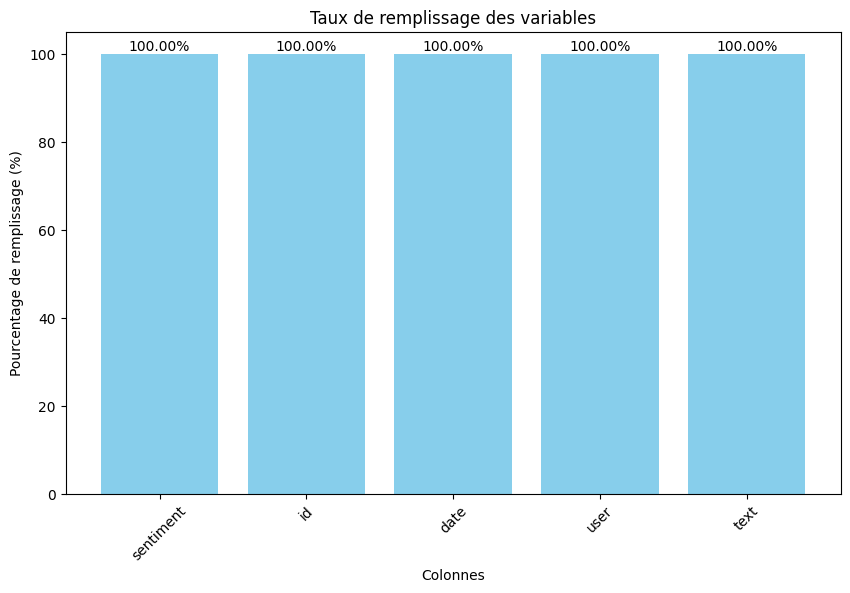

In [ ]:
# Nettoyage du DataFrame avec MLFlow
with mlflow.start_run(run_name="Nettoyage des Données"):

    # Supprimer la colonne inutile
    df = df.drop(columns=['query'])

    # Convertir les labels de sentiment
    df['sentiment'] = df['sentiment'].replace({4: 1})
    sentiment_counts_after = df['sentiment'].value_counts().to_dict()
    mlflow.log_param("Répartition des sentiments après conversion", sentiment_counts_after)

    # Calculer et enregistrer le taux de remplissage des colonnes
    taux_remplissage = df.notnull().mean() * 100
    mlflow.log_dict(taux_remplissage.to_dict(), "Taux_remplissage.json")

    # Créer un graphique du taux de remplissage
    plt.figure(figsize=(10, 6))
    bars = plt.bar(taux_remplissage.index, taux_remplissage, color='skyblue')
    plt.title("Taux de remplissage des variables")
    plt.ylabel("Pourcentage de remplissage (%)")
    plt.xlabel("Colonnes")
    plt.xticks(rotation=45)

    # Ajouter les pourcentages au-dessus de chaque barre
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

    # Sauvegarder le graphique
    plt.savefig("taux_remplissage_colonnes.png")

    # Enregistrer le graphique dans MLFlow comme artefact
    mlflow.log_artifact("taux_remplissage_colonnes.png")

    # Suppression des doublons
    avant_doublons = len(df)
    df = df.drop_duplicates(subset=['text'])
    apres_doublons = len(df)
    mlflow.log_param("Tweets_supprimes_doublons", avant_doublons - apres_doublons)

    # Suppression des tweets vides
    avant_vides = len(df)
    df = df[df['text'].str.strip() != ""]
    apres_vides = len(df)
    mlflow.log_param("Tweets_supprimes_vides", avant_vides - apres_vides)

    # Log de la taille finale des données
    mlflow.log_param("Nombre total de tweets après nettoyage", len(df))

### <font color='blue'>3.3 Nettoyage du texte des tweets</font><a class="anchor" id="partie3.3">

###### <font color='orange'>Intégration dans MLFlow</font>

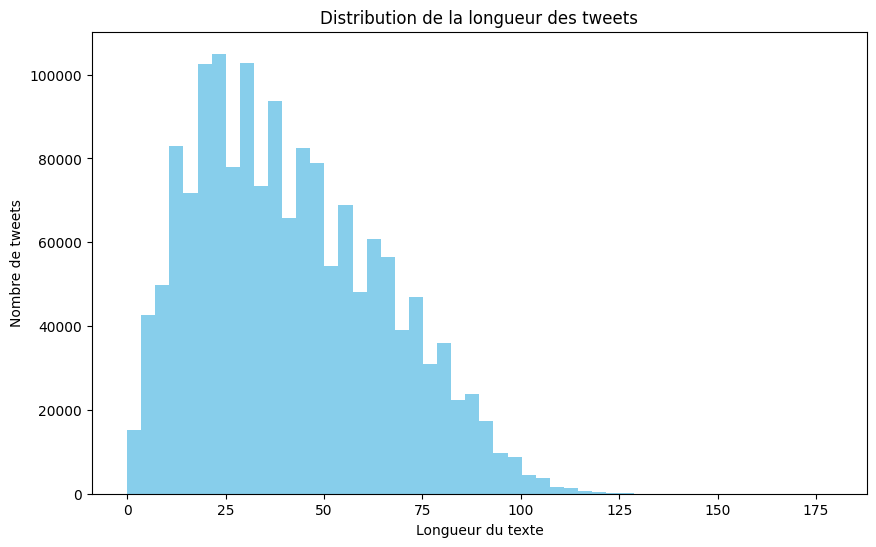

In [ ]:
# Run principal pour les transformations de texte
with mlflow.start_run(run_name="Transformations du Texte des Tweets", nested=False):

    # Nettoyage du Texte des Tweets avec un sous-run
    with mlflow.start_run(run_name="Nettoyage du Texte", nested=True):
        df['text_cleaned'] = df['text'].apply(nettoyer_texte)
        sample_texts = df[['text', 'text_cleaned']].sample(5).to_string()
        mlflow.log_text(sample_texts, "Exemple_text_nettoye.txt")

    # Analyse de la Longueur des Tweets avec un sous-run
    with mlflow.start_run(run_name="Analyse de la Longueur des Tweets", nested=True):
        df['text_length'] = df['text_cleaned'].apply(len)
        plt.figure(figsize=(10, 6))
        plt.hist(df['text_length'], bins=50, color='skyblue')
        plt.title("Distribution de la longueur des tweets")
        plt.xlabel("Longueur du texte")
        plt.ylabel("Nombre de tweets")
        plt.savefig("distribution_longueur_tweets.png")
        mlflow.log_artifact("distribution_longueur_tweets.png")

In [ ]:
# Nettoyage et suppression des lignes problématiques
df['text_cleaned'] = df['text_cleaned'].fillna(df['text'])
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['text_cleaned'] = df['text_cleaned'].replace('', np.nan)

# Supprimer les lignes problématiques
df = df[~df['text_cleaned'].isnull()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1573595 entries, 0 to 1599998
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1573595 non-null  int64 
 1   id            1573595 non-null  int64 
 2   date          1573595 non-null  object
 3   user          1573595 non-null  object
 4   text          1573595 non-null  object
 5   text_cleaned  1573595 non-null  object
 6   text_length   1573595 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 96.0+ MB


###### **<font color='green'>Observations</font>**

- Répartition des Labels de Sentiment :
On observe un équilibre entre les tweets positifs et négatifs dans le dataset (800 000 pour chaque label). Cela est idéal pour l'entraînement d'un modèle de classification, car il ne sera pas biaisé par une classe dominante.

- Échantillons de Texte Nettoyé :
Les exemples montrent que la fonction de nettoyage fonctionne bien, retirant efficacement les mentions, les hashtags, la ponctuation, les chiffres et les espaces supplémentaires.
Les phrases sont prêtes pour les étapes d'analyse plus avancées.

- Distribution de la Longueur des Tweets :
Le graphique montre une distribution asymétrique, avec une majorité des tweets entre 25 et 75 caractères. Cela peut nous aider à définir des limites de longueur pour le modèle, ou des seuils pour le padding et le truncating lors de l'utilisation des embeddings ou de modèles séquentiels.

## <font color='red'>4. Traitement des données</font><a class="anchor" id="partie4"></a>

### <font color='blue'>4.1 Prétraitement du texte</font><a class="anchor" id="partie4.1">

In [ ]:
# Appliquer et loguer dans MLFlow
with mlflow.start_run(run_name="Stemmatisation et Lemmatisation", nested=False):
    try:
        # Appliquer et loguer la stemmatisation
        with mlflow.start_run(run_name="Stemmatisation", nested=True):
            df['text_stemmed'] = df['text_cleaned'].apply(stemmer_texte)
            mlflow.log_text(df[['text_cleaned', 'text_stemmed']].sample(5).to_string(), "exemple_text_stemmed.txt")

        # Appliquer et loguer la lemmatisation
        with mlflow.start_run(run_name="Lemmatisation", nested=True):
            df['text_lemmatized'] = df['text_cleaned'].apply(lemmatizer_texte)
            mlflow.log_text(df[['text_cleaned', 'text_lemmatized']].sample(5).to_string(), "exemple_text_lemmatized.txt")

        # Enregistrer le nombre total de tweets après transformations
        mlflow.log_param("Nombre total de tweets après transformations", len(df))

    except Exception as e:
        print(f"Erreur lors du nettoyage des données : {e}")

In [ ]:
# Exporter les données nettoyées
df.to_csv('/content/drive/My Drive/projet_7/df_modele_final_vf.csv', index=False, encoding='utf-8')

### <font color='blue'>4.2 Vectorisation du texte</font><a class="anchor" id="partie4.2">

In [ ]:
# Appliquer BoW, TF-IDF classique, et TF-IDF avec N-grams
with mlflow.start_run(run_name="Vectorisation des Textes", nested=False):
    vectorization_methods = ["BoW", "TF-IDF", "TF-IDF N-grams"]  # Les trois méthodes
    text_versions = ["text_cleaned", "text_stemmed", "text_lemmatized"]

    for vectorization_type in vectorization_methods:
        for column_name in text_versions:
            try:
                # Créer un sous-run pour chaque type de vectorisation
                with mlflow.start_run(run_name=f"Vectorisation {vectorization_type} - {column_name}", nested=True):
                    if vectorization_type == "TF-IDF N-grams":
                        # Spécifier le n-gram pour cette méthode
                        matrix = vectorize_and_log(df, column_name, vectorization_type="TF-IDF", ngram_range=(1, 2))
                    else:
                        # BoW et TF-IDF classique
                        matrix = vectorize_and_log(df, column_name, vectorization_type=vectorization_type)

            except Exception as e:
                print(f"Erreur lors de la vectorisation {vectorization_type} pour {column_name} : {e}")

## <font color='red'>5. Métrique Comparative : Buzz Score</font><a class="anchor" id="partie5"></a>

**Buzz Score : Justification et Calcul**
Dans le cadre de ce projet, l'objectif principal est de développer un modèle capable de prédire avec précision les sentiments exprimés dans des tweets. Cependant, certaines métriques traditionnelles, comme l'accuracy, peuvent ne pas refléter adéquatement les priorités spécifiques du client, la compagnie aérienne Air Paradis. En effet, dans ce contexte, les faux négatifs (tweets à risque classés comme positifs) ont des conséquences bien plus importantes que les faux positifs.

**Pourquoi le Buzz Score ?**
Le Buzz Score a été conçu pour fournir une mesure globale qui intègre plusieurs métriques clés tout en reflétant les priorités du client. Ce score est une combinaison pondérée des métriques suivantes :

- Recall (pondération : 40 %) : C'est la capacité du modèle à identifier correctement les tweets négatifs. Maximiser le recall est essentiel pour réduire les faux négatifs.
- F1-Score (pondération : 30 %) : Cette métrique équilibre le rappel et la précision, en reflétant à la fois la qualité des prédictions positives et négatives.
- AUC (Area Under the Curve) (pondération : 20 %) : Une mesure globale qui évalue la capacité du modèle à classer correctement les tweets sur l’ensemble des seuils.
- Precision (pondération : 10 %) : Bien que moins prioritaire, elle garantit que les prédictions positives restent fiables.

**Formule du Buzz Score**
La formule utilisée pour calculer le Buzz Score est la suivante :

Buzz Score
=
(
0.4
×
Recall
)
+
(
0.3
×
F1-Score
)
+
(
0.2
×
AUC
)
+
(
0.1
×
Precision
)
Buzz Score=(0.4×Recall)+(0.3×F1-Score)+(0.2×AUC)+(0.1×Precision)
Cette pondération a été choisie pour refléter les priorités opérationnelles d'Air Paradis :
- Réduction des faux négatifs : Les tweets à risque non détectés peuvent entraîner des crises médiatiques.
- Pertinence des prédictions positives : Les fausses alertes (faux positifs) sont acceptables, mais doivent être minimisées pour éviter des analyses inutiles.

Importance dans le projet
En utilisant le Buzz Score comme métrique principale, nous pourrons comparer efficacement les performances de différents modèles, en tenant compte à la fois de leur capacité à détecter les tweets négatifs et de leur utilité globale pour le client. Cette métrique sera également utilisée comme critère final pour sélectionner le modèle à déployer.

## <font color='red'>6. Modélisation Simple</font><a class="anchor" id="partie6"></a>

In [ ]:
# Modèles à tester pour la phase finale
final_models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=10, random_state=42)
}

# Prendre un échantillon de 500 000 tweets
df_sample = df.sample(500000, random_state=42)

In [ ]:
# ETAPE 1 - Tester les versions de texte
results_text_versions = []
for text_version in ["text_cleaned", "text_stemmed", "text_lemmatized"]:
    print(f"--- Test de la version du texte : {text_version} ---")
    X = vectorize_and_log(df_sample, text_version, vectorization_type="BoW")
    y = df_sample['sentiment'].values

    metrics, execution_time = train_and_evaluate_ml_model(
        model=final_models["Logistic Regression"],
        model_name="Logistic Regression",
        embedding_data=X,
        labels=y,
        embedding_type="BoW",
        text_version=text_version
    )

    # Stocker les résultats
    results_text_versions.append({
        "Text Version": text_version,
        **metrics,
        "Execution Time (s)": execution_time
    })

# Afficher les résultats
df_results_text_versions = pd.DataFrame(results_text_versions)
print("\n--- Résultats pour chaque version de texte ---")
display(df_results_text_versions)

--- Test de la version du texte : text_cleaned ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8171, Precision: 0.7191, Recall: 0.7904, F1: 0.7531
--- Test de la version du texte : text_stemmed ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8208, Precision: 0.7254, Recall: 0.7899, F1: 0.7562
--- Test de la version du texte : text_lemmatized ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8180, Precision: 0.7204, Recall: 0.7905, F1: 0.7538

--- Résultats pour chaque version de texte ---


,Text Version,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time (s)
0,text_cleaned,0.816955,0.719334,0.790293,0.753144,0.777385,0.817096,0.719105,0.790394,0.753066,0.777407,6.147597
1,text_stemmed,0.820553,0.725252,0.790033,0.756256,0.779526,0.820830,0.725357,0.789855,0.756233,0.779514,7.127094
2,text_lemmatized,0.818000,0.721158,0.790103,0.754055,0.777974,0.818038,0.720404,0.790513,0.753832,0.778003,6.603385


In [ ]:
df_results_text_versions.to_csv('/content/drive/My Drive/projet_7/comparaison_text_versions.csv', sep=";", index=False)

In [ ]:
# Meilleure version du texte choisie à partir de l'Étape 1
best_text_version = "text_stemmed"

# Tester les vectorisations
results_vectorizations = []
vectorization_methods = ["BoW", "TF-IDF", "TF-IDF N-grams"]  # Ajout de TF-IDF N-grams

for vectorization_type in vectorization_methods:
    print(f"--- Test de la vectorisation : {vectorization_type} ---")

    if vectorization_type == "TF-IDF N-grams":
        # Utiliser TF-IDF avec N-grams (unigrams et bigrams)
        X = vectorize_and_log(
            df_sample,
            column_name=best_text_version,
            vectorization_type="TF-IDF",
            ngram_range=(1, 2)
        )
    else:
        # BoW ou TF-IDF classique
        X = vectorize_and_log(
            df_sample,
            column_name=best_text_version,
            vectorization_type=vectorization_type
        )

    y = df_sample['sentiment'].values

    # Entraîner et évaluer la Régression Logistique
    metrics, execution_time = train_and_evaluate_ml_model(
        model=final_models["Logistic Regression"],
        model_name="Logistic Regression",
        embedding_data=X,
        labels=y,
        embedding_type=vectorization_type,
        text_version=best_text_version
    )

    # Stocker les résultats
    results_vectorizations.append({
        "Vectorization": vectorization_type,
        **metrics,
        "Execution Time (s)": execution_time
    })

# Afficher les résultats
df_results_vectorizations = pd.DataFrame(results_vectorizations)
print("\n--- Résultats pour chaque vectorisation ---")
display(df_results_vectorizations)

--- Test de la vectorisation : BoW ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8208, Precision: 0.7254, Recall: 0.7899, F1: 0.7562
--- Test de la vectorisation : TF-IDF ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8248, Precision: 0.7317, Recall: 0.7757, F1: 0.7531
--- Test de la vectorisation : TF-IDF N-grams ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8281, Precision: 0.7353, Recall: 0.7784, F1: 0.7562

--- Résultats pour chaque vectorisation ---


,Vectorization,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time (s)
0,BoW,0.820553,0.725252,0.790033,0.756256,0.779526,0.820830,0.725357,0.789855,0.756233,0.779514,7.057870
1,TF-IDF,0.824753,0.731287,0.776110,0.753029,0.774432,0.824759,0.731705,0.775727,0.753073,0.774335,7.877941
2,TF-IDF N-grams,0.827075,0.733181,0.778629,0.755218,0.776750,0.828145,0.735274,0.778381,0.756213,0.777373,8.005936


In [ ]:
df_results_vectorizations.to_csv('/content/drive/My Drive/projet_7/comparaison_vectoriztions.csv', sep=";", index=False)

In [ ]:
# Meilleure configuration choisie
best_text_version = "text_stemmed"
best_vectorization = "BoW"

# Tester plusieurs modèles
results_models = []

# Vectorisation avec gestion de TF-IDF N-grams
if best_vectorization == "BoW":
    # Ajouter ngram_range=(1, 2) pour inclure unigrams et bigrams
    X = vectorize_and_log(
        df_sample,
        column_name=best_text_version,
        vectorization_type="BoW",
        ngram_range=(1, 2)
    )
else:
    # Autres vectorisations classiques (BoW ou TF-IDF classique)
    X = vectorize_and_log(
        df_sample,
        column_name=best_text_version,
        vectorization_type=best_vectorization
    )

y = df_sample['sentiment'].values

# Boucle pour tester plusieurs modèles
for model_name, model in final_models.items():
    print(f"--- Test du modèle : {model_name} ---")
    try:
        metrics, execution_time = train_and_evaluate_ml_model(
            model=model,
            model_name=model_name,
            embedding_data=X,
            labels=y,
            embedding_type=best_vectorization,
            text_version=best_text_version
        )

        # Stocker les résultats
        results_models.append({
            "Model": model_name,
            **metrics,
            "Execution Time (s)": execution_time
        })

    except Exception as e:
        print(f"Erreur lors de l'entraînement de {model_name}: {str(e)}")
        results_models.append({
            "Model": model_name,
            "Erreur": str(e)
        })

# Afficher les résultats
df_results_models = pd.DataFrame(results_models)
print("\n--- Résultats pour chaque modèle ---")
display(df_results_models)

--- Test du modèle : Naive Bayes ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8112, Precision: 0.7288, Recall: 0.7568, F1: 0.7426
--- Test du modèle : Logistic Regression ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8245, Precision: 0.7275, Recall: 0.7938, F1: 0.7592
--- Test du modèle : Random Forest ---

--- Pli 1 ---

--- Pli 2 ---

--- Pli 3 ---

--- Pli 4 ---

--- Pli 5 ---

--- Résultats sur le jeu de test ---
AUC: 0.8053, Precision: 0.7237, Recall: 0.7435, F1: 0.7335
--- Test du modèle : LightGBM ---

--- Pli 1 ---
[LightGBM] [Info] Number of positive: 160360, number of negative: 159640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.611996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

,Model,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time (s)
0,Naive Bayes,0.810178,0.727767,0.758355,0.742742,0.760977,0.811224,0.728805,0.756830,0.742553,0.760623,2.885417
1,Logistic Regression,0.823096,0.726329,0.793900,0.758610,0.782395,0.824541,0.727489,0.793846,0.759220,0.782961,7.450331
2,Random Forest,0.803249,0.722586,0.742376,0.732347,0.749563,0.805322,0.723706,0.743520,0.733479,0.750887,8486.602078
3,LightGBM,0.814909,0.705503,0.811281,0.754702,0.784455,0.814520,0.705508,0.809491,0.753931,0.783430,20.963065
4,XGBoost,0.813078,0.701822,0.821019,0.756753,0.788231,0.813629,0.702538,0.819149,0.756375,0.787552,10.452811
5,Bagging (Logistic Regression),0.822956,0.726023,0.794005,0.758491,0.782343,0.824440,0.727725,0.793407,0.759148,0.782768,54.803576


In [ ]:
df_results_models.to_csv('/content/drive/My Drive/projet_7/comparaison_models_ml.csv', sep=";", index=False)

## <font color='red'>7. Modélisation Avancée</font><a class="anchor" id="partie7"></a>


### <font color='blue'>7.1 Word Embedding</font><a class="anchor" id="partie7.1"></a>

###### **<font color='green'>Word2Vec</font>**

In [ ]:
# 1. Préparer les phrases (liste de listes de mots) à partir des tweets
sentences = df['text_stemmed'].apply(lambda x: x.split()).tolist()

# 2. Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# 3. Sauvegarder le modèle pour une utilisation future
word2vec_model.save("/content/drive/My Drive/projet_7/word2vec_tweets.model")

# Loguer l'embedding dans MLFlow
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Entraînement Word2Vec"):
    mlflow.log_param("vector_size", 100)
    mlflow.log_param("window", 5)
    mlflow.log_param("min_count", 5)
    mlflow.log_artifact("/content/drive/My Drive/projet_7/word2vec_tweets.model")

In [ ]:
# Vérifier l'existence de mots dans le vocabulaire avant de demander les mots similaires
def print_similar_words(word, model, topn=5):
    if word in model.wv:
        print(f"Mots similaires à '{word}': {model.wv.most_similar(word, topn=topn)}")
    else:
        print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")

# Tester avec des mots plus fréquents dans le domaine aérien
print_similar_words("plane", word2vec_model)
print_similar_words("late", word2vec_model)
print_similar_words("fly", word2vec_model)

Mots similaires à 'plane': [('flight', 0.8318514823913574), ('airplan', 0.7119559645652771), ('jet', 0.6522073745727539), ('atlant', 0.6434814929962158), ('airport', 0.6416956186294556)]
Mots similaires à 'late': [('earli', 0.6862510442733765), ('earlier', 0.5474535822868347), ('pm', 0.5314387083053589), ('tire', 0.5162385702133179), ('busi', 0.4959926903247833)]
Le mot 'fly' n'est pas dans le vocabulaire du modèle.


###### **<font color='green'>USE</font>**

In [ ]:
# Charger le modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Calculer les embeddings en batchs pour éviter les problèmes de mémoire
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Embeddings USE"):
    tweets = df['text_stemmed'].tolist()
    use_embeddings = batch_embeddings(tweets)
    mlflow.log_param("embedding_type", "USE")
    # Loguer une partie des embeddings en tant qu'artefact pour inspection
    np.save("use_embeddings_sample.npy", use_embeddings[:5])
    mlflow.log_artifact("use_embeddings_sample.npy")

###### **<font color='green'>FastText</font>**

In [ ]:
# 1. Préparer les phrases (liste de listes de mots) à partir des tweets
sentences = df['text_stemmed'].apply(lambda x: x.split()).tolist()

# 2. Entraîner le modèle FastText
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

# 3. Sauvegarder le modèle pour une utilisation future
fasttext_model.save("/content/drive/My Drive/projet_7/fasttext_tweets.model")

# Vérification de mots similaires
def print_similar_words_fasttext(word, model, topn=5):
    if word in model.wv:
        print(f"Mots similaires à '{word}': {model.wv.most_similar(word, topn=topn)}")
    else:
        print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")

# Exemple
print_similar_words_fasttext("plane", fasttext_model)

# Extraction des embeddings FastText
fasttext_embeddings = get_avg_word2vec_embeddings(df['text_stemmed'].apply(str.split), fasttext_model, 100)

Mots similaires à 'plane': [('airprt', 0.8365820646286011), ('flight', 0.8301228880882263), ('airplan', 0.8286897540092468), ('airbu', 0.8169044852256775), ('airb', 0.7701421976089478)]


###### **<font color='green'>ELMo</font>**

In [ ]:
# Charger le modèle ELMo depuis TensorFlow Hub
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

# Calculer les embeddings en batchs pour éviter les problèmes de mémoire
tweets = df['text_stemmed'].tolist()
elmo_embeddings = batch_embeddings_elmo(tweets)

# Loguer les embeddings ELMo
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Embeddings ELMo"):
    mlflow.log_param("embedding_type", "ELMo")
    # Sauvegarder une partie des embeddings pour inspection
    np.save("elmo_embeddings_sample.npy", elmo_embeddings[:5])  # Échantillon
    mlflow.log_artifact("elmo_embeddings_sample.npy")

###### **<font color='green'>Glove</font>**

In [ ]:
# Charger les vecteurs GloVe
glove_file = "/content/drive/My Drive/projet_7/glove.twitter.27B.200d.txt"
glove_embeddings_index = load_glove_vectors(glove_file)

# Calculer les embeddings moyens GloVe pour chaque phrase
glove_embeddings = get_avg_glove_embeddings(df['text_stemmed'].apply(str.split), glove_embeddings_index, 100)
print(glove_embeddings.shape)

# Loguer les embeddings GloVe dans MLflow
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="Embeddings GloVe"):
    mlflow.log_param("embedding_type", "GloVe")
    mlflow.log_param("vector_size", 100)
    # Sauvegarder un échantillon des embeddings pour inspection
    np.save("glove_embeddings_sample.npy", glove_embeddings[:5])  # Échantillon
    mlflow.log_artifact("glove_embeddings_sample.npy")

(1573595, 100)


### <font color='blue'>7.2 Modelisation</font><a class="anchor" id="partie7.2"></a>

##### **<font color='green'>KERAS Dense</font>**

In [ ]:
# Prendre un échantillon de 500 000 tweets
df_sample = df.sample(500000, random_state=42)

In [ ]:
model_scores_keras = []

In [ ]:
# Obtenir les embeddings FastText, Word2Vec, ELMo, Glove et USE

elmo_embeddings = batch_embeddings_elmo(df_sample['text_stemmed'].tolist())
use_embeddings = batch_embeddings(df_sample['text_stemmed'].tolist())
glove_embeddings = get_avg_glove_embeddings(df_sample['text_stemmed'].apply(str.split), glove_embeddings_index, 100)
fasttext_embeddings = get_avg_word2vec_embeddings(df_sample['text_stemmed'].apply(str.split), fasttext_model, 100)
word2vec_embeddings = get_avg_word2vec_embeddings(df_sample['text_stemmed'].apply(str.split), word2vec_model, 100)


--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


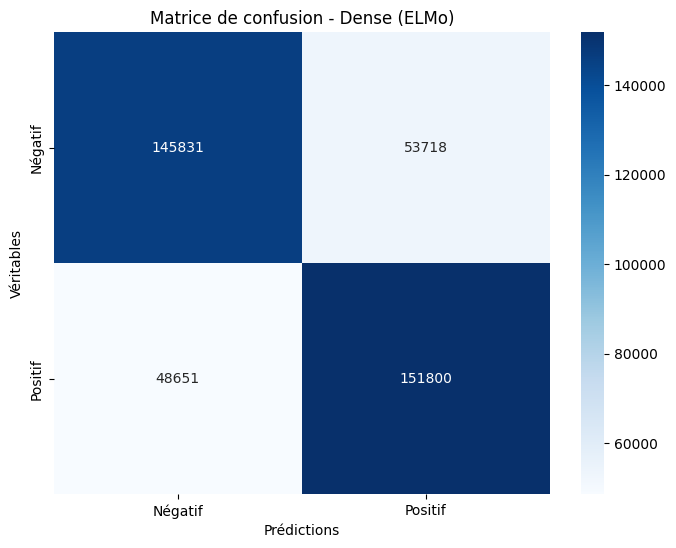

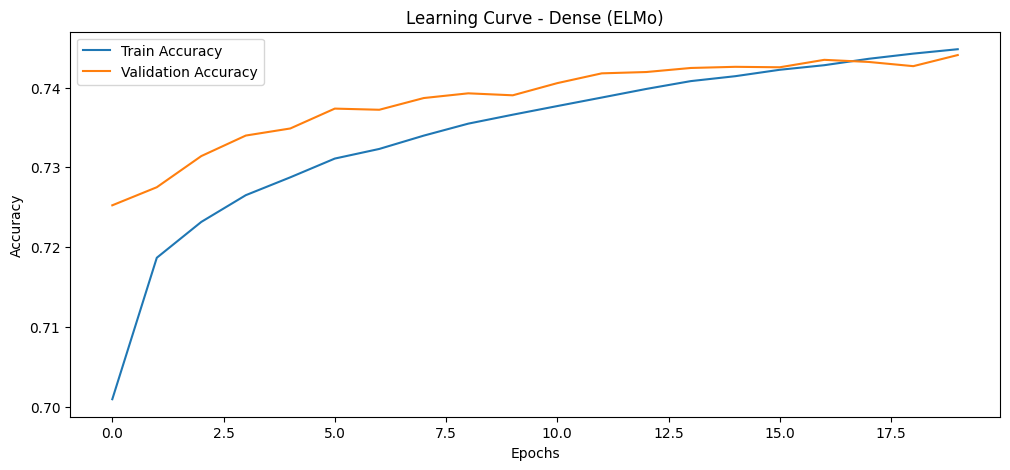

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Résultats sur le jeu de test ---
AUC: 0.8286, Precision: 0.7439, Recall: 0.7615, F1: 0.7526
Temps d'exécution total pour Dense: 1040.63 secondes

--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


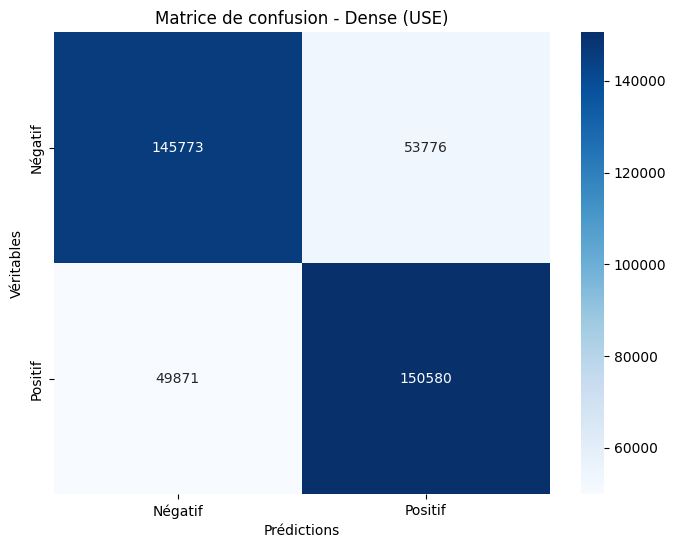

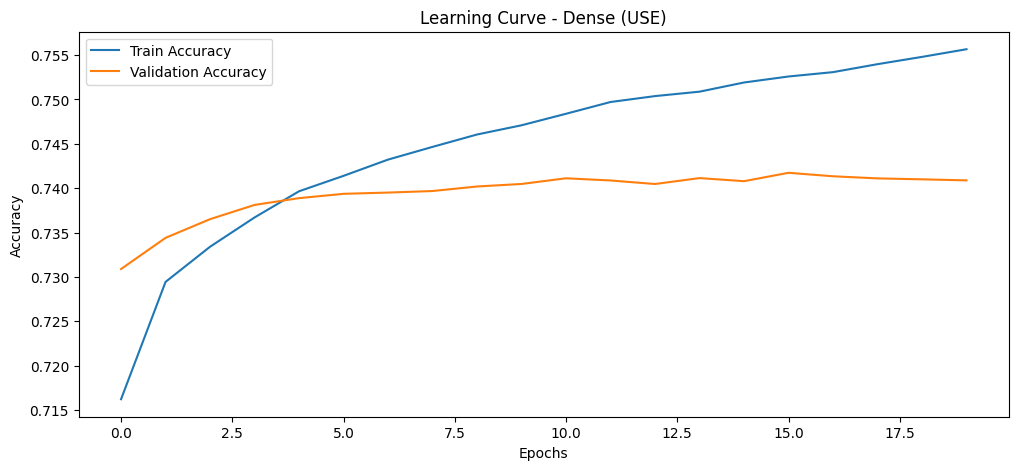

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Résultats sur le jeu de test ---
AUC: 0.8234, Precision: 0.7423, Recall: 0.7414, F1: 0.7419
Temps d'exécution total pour Dense: 986.76 secondes

--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 991us/step


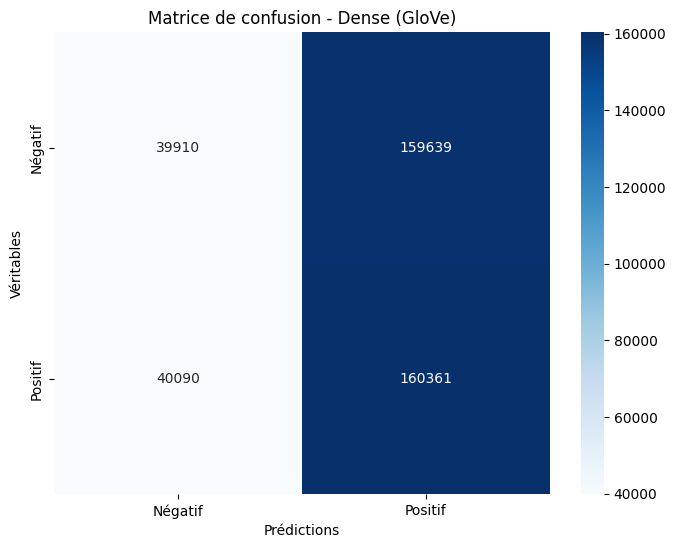

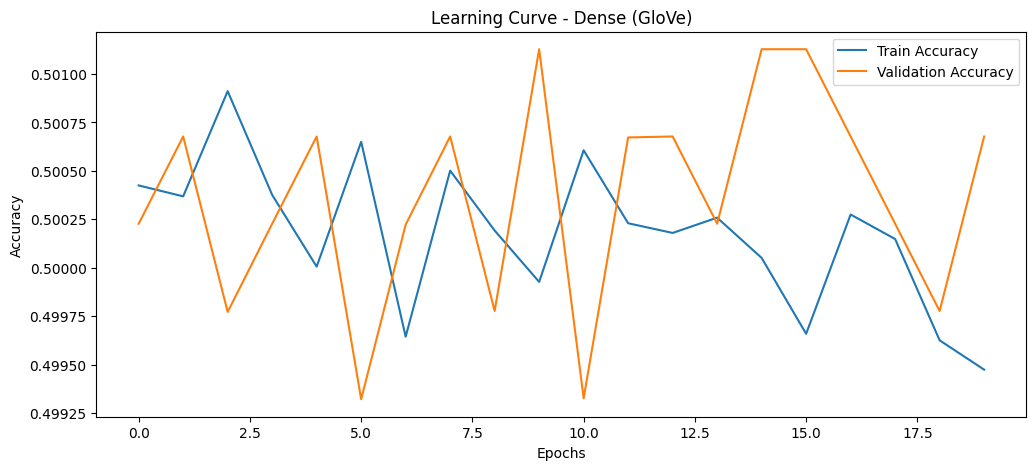

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Résultats sur le jeu de test ---
AUC: 0.5000, Precision: 0.5011, Recall: 1.0000, F1: 0.6677
Temps d'exécution total pour Dense: 946.89 secondes

--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


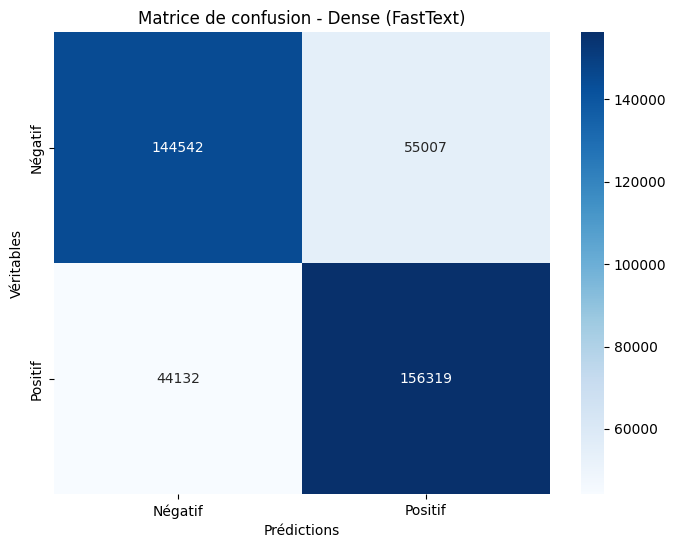

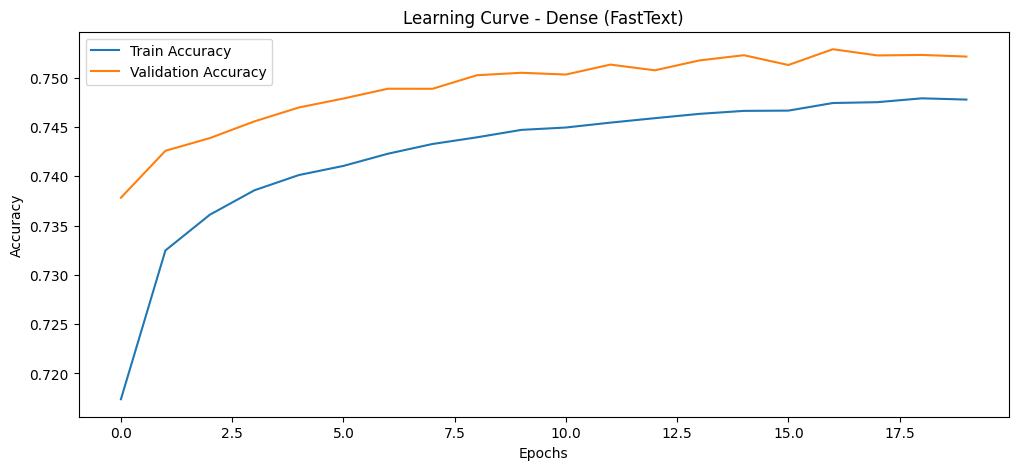

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Résultats sur le jeu de test ---
AUC: 0.8387, Precision: 0.7571, Recall: 0.7591, F1: 0.7581
Temps d'exécution total pour Dense: 963.73 secondes

--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


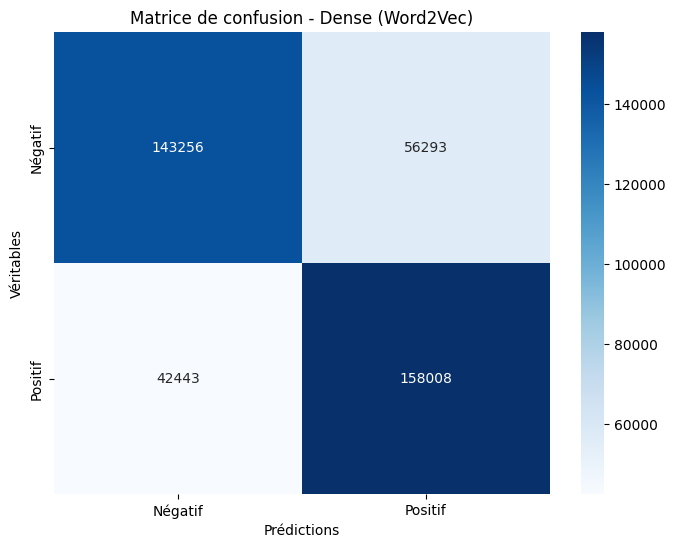

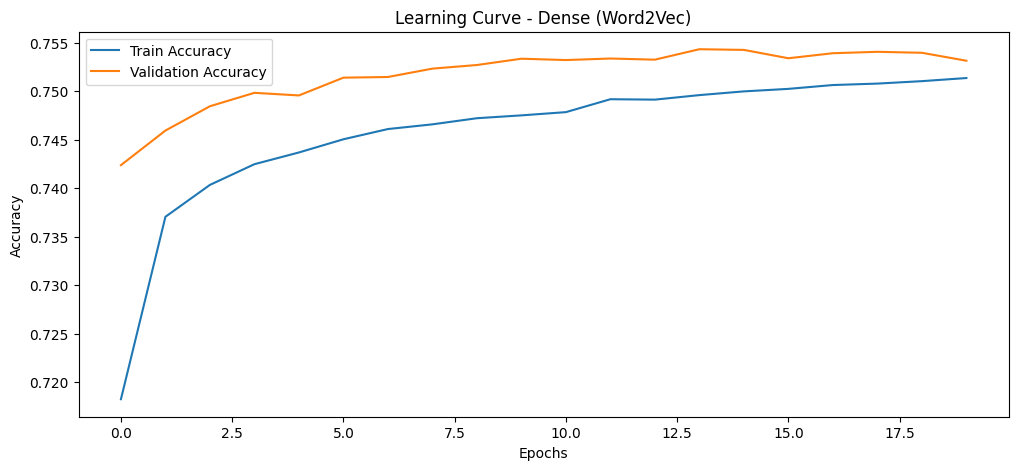

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Résultats sur le jeu de test ---
AUC: 0.8386, Precision: 0.7487, Recall: 0.7742, F1: 0.7612
Temps d'exécution total pour Dense: 960.72 secondes


In [ ]:
# Exécuter le modèle Dense avec ELMo
with mlflow.start_run(run_name="Keras - Dense - ELMo", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=elmo_embeddings,
        labels=df_sample['sentiment'].values,
        embedding_type="ELMo"
    )

# Exécuter le modèle Dense avec USE
with mlflow.start_run(run_name="Keras - Dense - USE", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=use_embeddings,
        labels=df_sample['sentiment'].values,
        embedding_type="USE"
    )

# Exécuter le modèle Dense avec les embeddings GloVe
with mlflow.start_run(run_name="Keras - Dense - GloVe", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=glove_embeddings,
        labels=df_sample['sentiment'].values,
        embedding_type="GloVe"
    )

# Exécuter le modèle Dense avec FastText
with mlflow.start_run(run_name="Keras - Dense - FastText", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=fasttext_embeddings,
        labels=df_sample['sentiment'].values,
        embedding_type="FastText"
    )

# Exécuter le modèle Dense avec Word2Vec
with mlflow.start_run(run_name="Keras - Dense - Word2Vec", nested=False):
    train_and_evaluate_keras_model_dense(
        model_name="Dense",
        embedding_data=word2vec_embeddings,
        labels=df_sample['sentiment'].values,
        embedding_type="Word2Vec"
    )

##### **<font color='green'>KERAS LSTM</font>**

In [ ]:
# Initialiser la liste globale des scores pour les modèles Keras
model_scores_keras = []

# Initialiser l'embedding selon l'étape précédente
word2vec_embeddings = get_avg_word2vec_embeddings(df_sample['text_stemmed'].apply(str.split), word2vec_model, 100)

# Créer le run principal pour Keras - LSTM
ensure_no_active_run()
with mlflow.start_run(run_name="KERAS - LSTM", nested=False):
    # Exécuter l’entraînement pour Word2Vec en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="Word2Vec", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM",
            embedding_data=word2vec_embeddings,
            labels=df_sample['sentiment'].values,
            embedding_type="Word2Vec",
            bidirectional=False
        )


--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Temps d'exécution total pour LSTM: 1855.05 secondes


##### **<font color='green'>KERAS LSTM Bidirectionnel</font>**

In [ ]:
# Initialiser la liste globale des scores pour les modèles Keras
model_scores_keras = []

# Initialiser l'embedding selon l'étape KERAS Dense
word2vec_embeddings = get_avg_word2vec_embeddings(df['text_stemmed'].apply(str.split), word2vec_model, 100)

# Créer le run principal pour Keras - LSTM Bidirectionnel
ensure_no_active_run()
with mlflow.start_run(run_name="KERAS - LSTM Bidirectionnel", nested=False):
    # Exécuter l’entraînement pour Word2Vec en tant que sous-run
    ensure_no_active_run()
    with mlflow.start_run(run_name="Word2Vec", nested=True):
        train_and_evaluate_keras_model_lstm(
            model_name="LSTM Bidirectionnel",
            embedding_data=word2vec_embeddings,
            labels=df['sentiment'].values,
            embedding_type="Word2Vec",
            bidirectional=True
        )


--- Pli 1 ---
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step

--- Pli 2 ---
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step

--- Pli 3 ---
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step

--- Pli 4 ---
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step

--- Pli 5 ---
7868/7868 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
9835/9835 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Temps d'exécution total pour LSTM Bidirectionnel: 8801.26 secondes


##### **<font color='green'>Comparatif</font>**

In [7]:
# Chargement du fichier CSV dans un DataFrame
df = pd.read_csv('/content/drive/My Drive/projet_7/comparaison_modeles_dl.csv', encoding='latin1', sep=";")

In [8]:
display(df)

,Model,Embedding,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time (s)
0,LSTM,Word2Vec,0.840670,0.753061,0.767380,0.760124,0.778429,0.842301,0.754246,0.775348,0.764651,0.783419,"1855,05"
1,Dense,Word2Vec,0.836456,0.737587,0.788262,0.761865,0.784915,0.838620,0.748726,0.774170,0.761236,0.780636,"960,72"
2,LSTM Bidirectionnel,Word2Vec,0.847887,0.760923,0.772408,0.766600,0.784613,0.849590,0.764460,0.769295,0.766870,0.784143,"8801,26"


In [ ]:
# Appel de la fonction pour afficher le tableau récapitulatif
df_summary_keras = display_score_summary_keras()
display(df_summary_keras)

In [ ]:
df_summary_keras.to_csv('/content/drive/My Drive/projet_7/comparaison_emnbeding_keras_LSTM_bi_2.csv', sep=";", index=False)

## <font color='red'>8. Modèle BERT</font><a class="anchor" id="partie8"></a>

### <font color='blue'>8.1 Pipeline Hugging Face (RoBERTa)</font><a class="anchor" id="partie8.1"></a>

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Exécution du pipeline BERT...


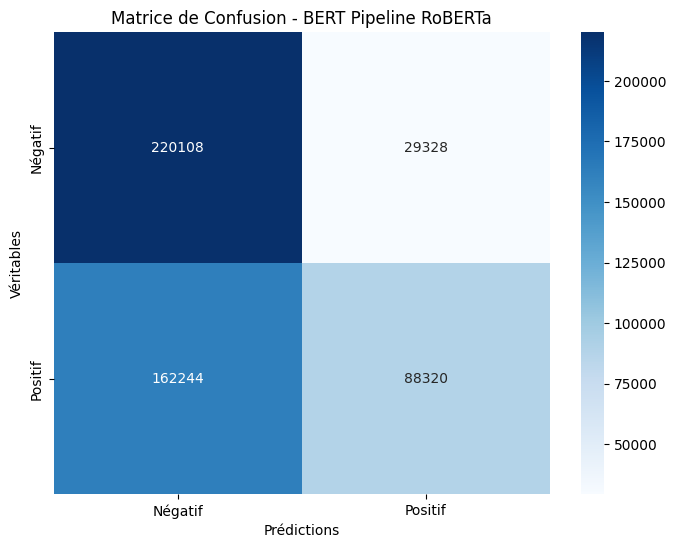

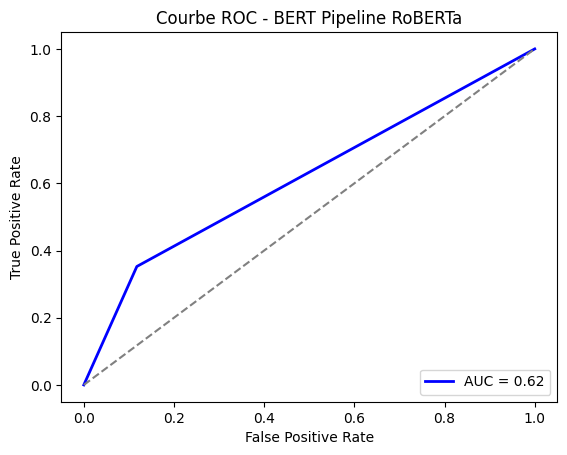


--- Résultats pour BERT Pipeline RoBERTa ---
Precision: 0.7507, Recall: 0.3525, F1 Score: 0.4797, AUC: 0.6175, Buzz Score: 0.4835, Execution Time: 3963.83s


In [ ]:
# Exemple d'exécution sur un échantillon
model_scores_bert = []  # Réinitialiser la liste globale
results = train_and_evaluate_bert_pipeline(df, text_column="text_stemmed", label_column="sentiment", sample_size=500000)

In [ ]:
# Afficher et sauvegarder les résultats
df_summary_bert = display_score_summary_bert()
display(df_summary_bert)

                   Model  Precision    Recall  F1 Score       AUC  Buzz Score  \
0  BERT Pipeline RoBERTa   0.750714  0.352485  0.479724  0.617454    0.483473   

   Execution Time  
0     3963.826373  


,Model,Precision,Recall,F1 Score,AUC,Buzz Score,Execution Time
0,BERT Pipeline RoBERTa,0.750714,0.352485,0.479724,0.617454,0.483473,3963.826373


In [ ]:
df_summary_bert.to_csv('/content/drive/My Drive/projet_7/comparaison_pipeline_RoBERTa.csv', sep=";", index=False)

### <font color='blue'>8.2 Embeddings BERT + LSTM Bidirectionnel</font><a class="anchor" id="partie8.2"></a>

In [ ]:
with open('/content/drive/My Drive/projet_7/token.txt', 'r') as file:
    hf_token = file.read().strip()

from huggingface_hub import login
login(hf_token)

In [ ]:
# Réduire le dataset à un échantillon si nécessaire
sample_size = 500000  # Taille de l'échantillon
if len(df) > sample_size:
    df_sample = df.sample(sample_size, random_state=42)
else:
    df_sample = df.copy()

texts = df_sample['text_stemmed'].tolist()
labels = df_sample['sentiment'].values

# Charger le modèle BERT et le tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Appliquer l'embedding BERT aux tweets de l'échantillon
with mlflow.start_run(run_name="Embedding BERT (Sample Dataset)"):
    bert_embeddings = get_bert_embeddings_batch(texts)
    print("Forme des embeddings BERT:", bert_embeddings.shape)
    np.save("bert_embeddings_sample.npy", bert_embeddings)
    mlflow.log_artifact("bert_embeddings_sample.npy")

# Vérifier et transformer les embeddings BERT en 3D si nécessaire
if len(bert_embeddings.shape) == 2:
    bert_embeddings = bert_embeddings[:, np.newaxis, :]


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Forme des embeddings BERT: (500000, 768)


In [ ]:
model_scores_bert = []

Train/Validation : (400000, 1, 768) (400000,)
Test : (100000, 1, 768) (100000,)

--- Pli 1 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Pli 2 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Pli 3 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Pli 4 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

--- Pli 5 ---
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Temps total: 2452.38 secondes


{'Mean AUC': 0.8145840160422182,
 'Mean Precision': 0.7372391594244438,
 'Mean Recall': 0.7286768329165143,
 'Mean F1 Score': 0.7327618342135087,
 'Buzz Score': 0.7479400025815465,
 'Test AUC': 0.816441670257475,
 'Test Precision': 0.7329544341009309,
 'Test Recall': 0.7462933769680522,
 'Test F1 Score': 0.7395637643615653,
 'Test Buzz Score': 0.7569702575572786,
 'Execution Time': 2452.3829777240753}

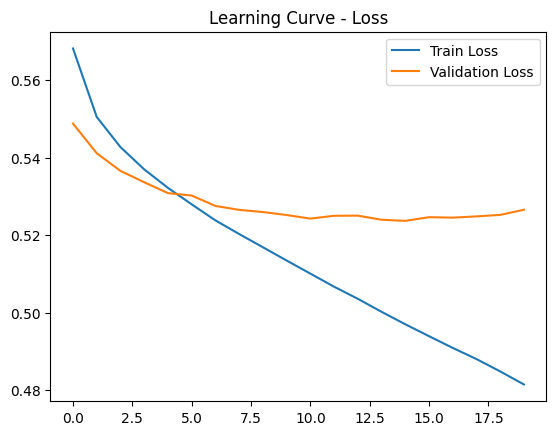

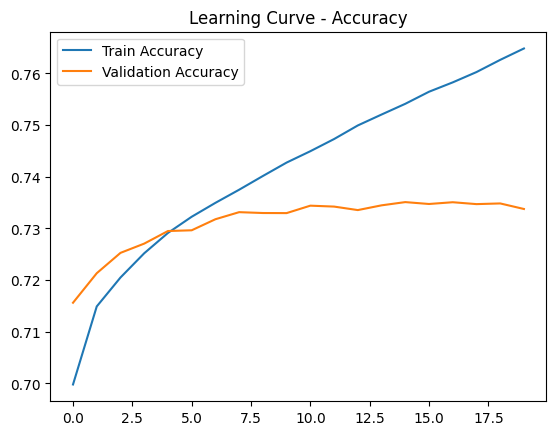

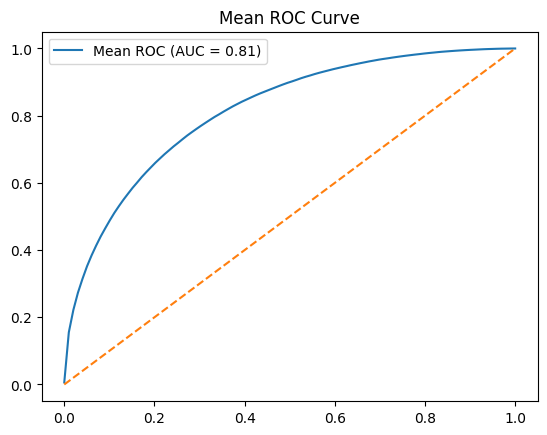

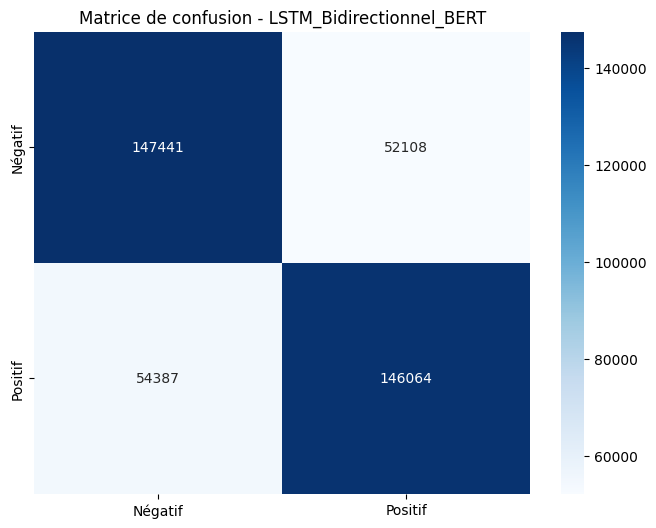

In [ ]:
# Exécution finale du modèle
train_and_evaluate_bert_lstm(
    model_name="LSTM_Bidirectionnel_BERT",
    embedding_data=bert_embeddings,  # Embeddings calculés pour l'échantillon
    labels=df_sample['sentiment'].values,  # Labels de l'échantillon
    embedding_type="BERT"
)

In [ ]:
# Affichage des résultats
score_summary_bert()

                      Model Embedding  Mean AUC  Mean Precision  Mean Recall  \
0  LSTM_Bidirectionnel_BERT      BERT  0.814584        0.737239     0.728677   

   Mean F1 Score  Buzz Score  Test AUC  Test Precision  Test Recall  \
0       0.732762     0.74794  0.816442        0.732954     0.746293   

   Test F1 Score  Test Buzz Score  Execution Time  
0       0.739564          0.75697     2452.382978  


,Model,Embedding,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time
0,LSTM_Bidirectionnel_BERT,BERT,0.814584,0.737239,0.728677,0.732762,0.74794,0.816442,0.732954,0.746293,0.739564,0.75697,2452.382978


In [ ]:
df_scores = pd.DataFrame(model_scores_bert)

# Vérifie le DataFrame
print(df_scores)

                      Model Embedding  Mean AUC  Mean Precision  Mean Recall  \
0  LSTM_Bidirectionnel_BERT      BERT  0.814584        0.737239     0.728677   

   Mean F1 Score  Buzz Score  Test AUC  Test Precision  Test Recall  \
0       0.732762     0.74794  0.816442        0.732954     0.746293   

   Test F1 Score  Test Buzz Score  Execution Time  
0       0.739564          0.75697     2452.382978  


In [ ]:
df_scores.to_csv('/content/drive/My Drive/projet_7/comparaison_embeddingBERT_modeleLSTMbi.csv', sep=";", index=False)

### <font color='blue'>8.3 BERT Fine-Tuning (PyTorch)</font><a class="anchor" id="partie8.3"></a>

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Dataset personnalisé pour préparer les données pour BERT.

        Args:
            texts (list): Liste des textes à inclure dans le dataset.
            labels (list): Liste des labels correspondants.
            tokenizer (transformers.BertTokenizer): Tokenizer pré-entraîné de BERT.
            max_length (int): Longueur maximale des séquences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Récupère un élément du dataset.
        """
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs


In [ ]:
model_scores_pytorch = []

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


--- Pli 1/5 ---


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Pli 2/5 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Pli 3/5 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Pli 4/5 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Pli 5/5 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                       Model  Mean AUC  Mean Precision  Mean Recall  \
0  PyTorch_BERT_StratifiedCV  0.666073        0.733154     0.667898   

   Mean F1 Score  Buzz Score  Test AUC  Test Precision  Test Recall  \
0       0.600132    0.653729  0.776482        0.801849     0.735558   

   Test F1 Score  Test Buzz Score  Execution Time  
0       0.767274         0.759887    37563.224315  


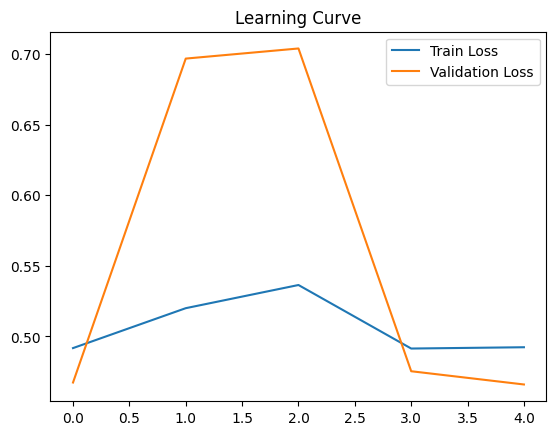

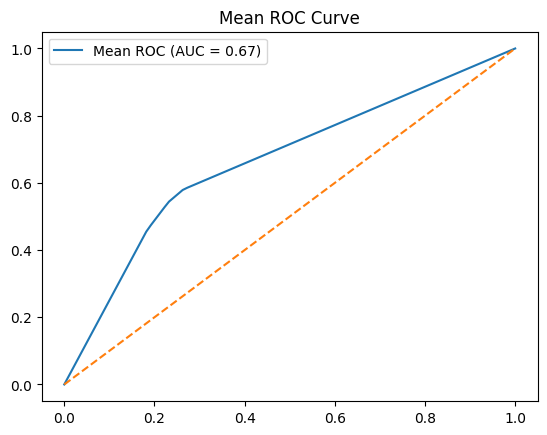

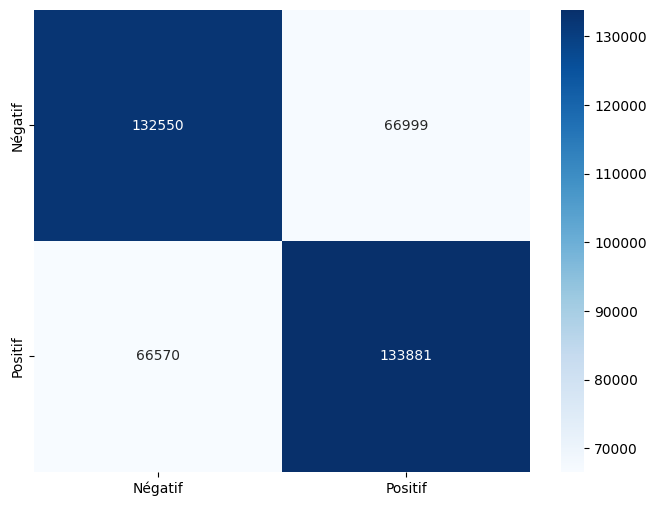

In [ ]:
# Définir les paramètres nécessaires
text_column = "text_stemmed"
label_column = "sentiment"
batch_size = 16
epochs = 15
learning_rate = 3e-5
n_splits = 5

# Appeler la fonction pour entraîner et évaluer le modèle
results_pytorch = train_and_evaluate_pytorch_bert(
    df=df,
    text_column=text_column,
    label_column=label_column,
    model_name="PyTorch_BERT_StratifiedCV",
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
    n_splits=n_splits
)

# Afficher les résultats finaux
df_scores_pytorch = pd.DataFrame(results_pytorch)
print(df_scores_pytorch)

In [ ]:
df_summary_pytorch = score_summary_pytorch()
display(df_summary_pytorch)

                       Model  Mean AUC  Mean Precision  Mean Recall  \
0  PyTorch_BERT_StratifiedCV  0.666073        0.733154     0.667898   

   Mean F1 Score  Buzz Score  Test AUC  Test Precision  Test Recall  \
0       0.600132    0.653729  0.776482        0.801849     0.735558   

   Test F1 Score  Test Buzz Score  Execution Time  
0       0.767274         0.759887    37563.224315  


,Model,Mean AUC,Mean Precision,Mean Recall,Mean F1 Score,Buzz Score,Test AUC,Test Precision,Test Recall,Test F1 Score,Test Buzz Score,Execution Time
0,PyTorch_BERT_StratifiedCV,0.666073,0.733154,0.667898,0.600132,0.653729,0.776482,0.801849,0.735558,0.767274,0.759887,37563.224315


In [ ]:
df_summary_pytorch.to_csv('/content/drive/My Drive/projet_7/comparaison_model_BERT_pytorch.csv', sep=";", index=False)